In [1]:
import requests
import pandas as pd

In [2]:
from google_play_scraper import reviews as play_reviews, Sort


In [3]:
# 1. Scrape Google Play Store Reviews (multi-country)
# ---------------------------
def get_playstore_reviews(app_id, countries, max_reviews=10000):
    all_reviews = []
    for country in countries:
        print(f"\nScraping Play Store reviews ({country})...")
        token = None
        country_reviews = []
        while True:
            reviews, token = play_reviews(
                app_id,
                lang='en',
                country=country.lower(),
                sort=Sort.NEWEST,
                count=200,
                continuation_token=token
            )
            for r in reviews:
                r["country"] = country.upper()
            country_reviews.extend(reviews)
            print(f"Collected {len(country_reviews)} Play Store reviews for {country} so far...")

            if not token or len(country_reviews) >= max_reviews:
                break
        all_reviews.extend(country_reviews)
    return all_reviews

In [4]:
# 2. Scrape Apple App Store Reviews (multi-country)
# ---------------------------
def get_appstore_reviews(app_id, country="us", pages=10):
    """Scrape up to ~50 reviews per page. For 500 reviews, use ~10 pages."""
    all_reviews = []
    for page in range(1, pages + 1):
        url = f"https://itunes.apple.com/{country}/rss/customerreviews/id={app_id}/page={page}/json"
        r = requests.get(url)
        if r.status_code != 200:
            print(f"Error fetching page {page} for {country}: {r.status_code}")
            break

        data = r.json()
        if "feed" not in data or "entry" not in data["feed"]:
            print(f"No more reviews found on page {page} for {country}")
            break

        entries = data["feed"]["entry"]

        # First entry is the app itself
        for review in entries[1:]:
            all_reviews.append({
                "username": review["author"]["name"]["label"],
                "review": review["content"]["label"],
                "rating": int(review["im:rating"]["label"]),
                "date": review["updated"]["label"],
                "country": country.upper()
            })

        print(f"Fetched {len(all_reviews)} reviews so far for {country}...")

        if len(all_reviews) >= 500:  # stop after 500
            break

    return all_reviews



In [5]:
# 3. Run Scrapers
# ---------------------------
play_countries = ["NG", "CA", "US", "GB"]
app_countries = ["ng", "ca", "us", "gb"]
app_id = 363590051  # Netflix App Store ID


In [6]:
# Play Store
play_reviews_all = get_playstore_reviews("com.netflix.mediaclient", play_countries, max_reviews=10000)
play_df = pd.DataFrame(play_reviews_all)
play_df = play_df[['userName', 'content', 'score', 'at', 'country']]
play_df.rename(columns={'userName': 'username', 'content': 'review',
                        'score': 'rating', 'at': 'date'}, inplace=True)
play_df['source'] = 'Play Store'


Scraping Play Store reviews (NG)...
Collected 200 Play Store reviews for NG so far...
Collected 400 Play Store reviews for NG so far...
Collected 600 Play Store reviews for NG so far...
Collected 800 Play Store reviews for NG so far...
Collected 1000 Play Store reviews for NG so far...
Collected 1200 Play Store reviews for NG so far...
Collected 1400 Play Store reviews for NG so far...
Collected 1600 Play Store reviews for NG so far...
Collected 1800 Play Store reviews for NG so far...
Collected 2000 Play Store reviews for NG so far...
Collected 2200 Play Store reviews for NG so far...
Collected 2400 Play Store reviews for NG so far...
Collected 2600 Play Store reviews for NG so far...
Collected 2800 Play Store reviews for NG so far...
Collected 3000 Play Store reviews for NG so far...
Collected 3200 Play Store reviews for NG so far...
Collected 3400 Play Store reviews for NG so far...
Collected 3600 Play Store reviews for NG so far...
Collected 3800 Play Store reviews for NG so far..

In [7]:
# App Store
all_appstore_reviews = []
for c in app_countries:
    print(f"\nScraping App Store reviews ({c.upper()})...")
    reviews = get_appstore_reviews(app_id, country=c, pages=10)
    all_appstore_reviews.extend(reviews)

app_df = pd.DataFrame(all_appstore_reviews)
app_df['source'] = 'App Store'


Scraping App Store reviews (NG)...
Fetched 49 reviews so far for ng...
Fetched 98 reviews so far for ng...
Fetched 147 reviews so far for ng...
Fetched 196 reviews so far for ng...
Fetched 245 reviews so far for ng...
Fetched 294 reviews so far for ng...
Fetched 343 reviews so far for ng...
Fetched 392 reviews so far for ng...
Fetched 441 reviews so far for ng...
Fetched 490 reviews so far for ng...

Scraping App Store reviews (CA)...
Fetched 49 reviews so far for ca...
Fetched 98 reviews so far for ca...
Fetched 147 reviews so far for ca...
Fetched 196 reviews so far for ca...
Fetched 245 reviews so far for ca...
Fetched 294 reviews so far for ca...
Fetched 343 reviews so far for ca...
Fetched 392 reviews so far for ca...
Fetched 441 reviews so far for ca...
Fetched 490 reviews so far for ca...

Scraping App Store reviews (US)...
Fetched 49 reviews so far for us...
Fetched 98 reviews so far for us...
Fetched 147 reviews so far for us...
Fetched 196 reviews so far for us...
Fetched 24

In [8]:
combined_df = pd.concat([play_df, app_df], ignore_index=True)

In [9]:
combined_df

,username,review,rating,date,country,source
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store
...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,2025-07-27T11:15:11-07:00,GB,App Store
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,2025-07-27T06:14:32-07:00,GB,App Store
41957,Strangerthings1608,This is the best streaming service with banger...,5,2025-07-27T03:09:07-07:00,GB,App Store
41958,hugh wwe123,wwe,5,2025-07-26T22:35:08-07:00,GB,App Store


In [10]:
combined_df.to_csv(r"C:\Users\user\Documents\netflix_reviews.csv", index=False)

In [11]:
print("\n✅ Saved combined reviews to 'netflix_reviews_multi_country.csv'")
print(f"Play Store reviews: {len(play_df)}")
print(f"App Store reviews: {len(app_df)}")
print(f"Total combined: {len(combined_df)}")


✅ Saved combined reviews to 'netflix_reviews_multi_country.csv'
Play Store reviews: 40000
App Store reviews: 1960
Total combined: 41960


In [12]:
import re
import pandas as pd

In [13]:
stop_words = {
    "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
    "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
    "they","them","their","theirs","themselves","what","which","who","whom","this","that",
    "these","those","am","is","are","was","were","be","been","being","have","has","had",
    "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
    "until","while","of","at","by","for","with","about","against","between","into","through",
    "during","before","after","above","below","to","from","up","down","in","out","on","off",
    "over","under","again","further","then","once","here","there","when","where","why","how",
    "all","any","both","each","few","more","most","other","some","such","no","nor","not",
    "only","own","same","so","than","too","very","s","t","can","will","just","don","should",
    "now"
}


In [14]:
df = pd.read_csv("C:/Users/user/Documents/netflix_reviews.csv")

In [15]:
df

,username,review,rating,date,country,source
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store
...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,2025-07-27T11:15:11-07:00,GB,App Store
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,2025-07-27T06:14:32-07:00,GB,App Store
41957,Strangerthings1608,This is the best streaming service with banger...,5,2025-07-27T03:09:07-07:00,GB,App Store
41958,hugh wwe123,wwe,5,2025-07-26T22:35:08-07:00,GB,App Store


In [16]:
df = df.dropna(subset=["review"])

In [17]:
df

,username,review,rating,date,country,source
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store
...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,2025-07-27T11:15:11-07:00,GB,App Store
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,2025-07-27T06:14:32-07:00,GB,App Store
41957,Strangerthings1608,This is the best streaming service with banger...,5,2025-07-27T03:09:07-07:00,GB,App Store
41958,hugh wwe123,wwe,5,2025-07-26T22:35:08-07:00,GB,App Store


In [18]:
# Cleaning function
def clean_text(text):
    text = str(text).lower()                          # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)        # remove links
    text = re.sub(r"[^a-z\s]", "", text)              # remove punctuation & numbers
    text = re.sub(r"\s+", " ", text).strip()          # remove extra spaces
    # remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [19]:
# Apply cleaning
df["clean_review"] = df["review"].apply(clean_text)


In [20]:
df

,username,review,rating,date,country,source,clean_review
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice
...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,2025-07-27T11:15:11-07:00,GB,App Store,love netflix spend half time working half time...
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,2025-07-27T06:14:32-07:00,GB,App Store,app help full easy access lot favourite shows ...
41957,Strangerthings1608,This is the best streaming service with banger...,5,2025-07-27T03:09:07-07:00,GB,App Store,best streaming service bangers like stranger t...
41958,hugh wwe123,wwe,5,2025-07-26T22:35:08-07:00,GB,App Store,wwe


In [21]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [22]:
import pandas as pd

In [23]:
sia = SentimentIntensityAnalyzer()

def categorize_netflix_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"


In [24]:
# Apply to dataset
df["vader_score"] = df["clean_review"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
df["sentiment"] = df["vader_score"].apply(categorize_netflix_sentiment)

In [25]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive
...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,2025-07-27T11:15:11-07:00,GB,App Store,love netflix spend half time working half time...,0.6369,positive
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,2025-07-27T06:14:32-07:00,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive
41957,Strangerthings1608,This is the best streaming service with banger...,5,2025-07-27T03:09:07-07:00,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive
41958,hugh wwe123,wwe,5,2025-07-26T22:35:08-07:00,GB,App Store,wwe,0.0000,neutral


In [26]:
df['clean_review'][0]

'cancelled subscription still get charged'

In [27]:
# 5. Sentiment from star ratings
# -----------------------------
def sentiment_from_rating(rating):
    if rating >= 4:   # 4 or 5 stars
        return "positive"
    elif rating == 3: # middle rating
        return "neutral"
    else:             # 1 or 2 stars
        return "negative"


In [28]:
df["sentiment_rating"] = df["rating"].apply(sentiment_from_rating)


In [29]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative,negative
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive,positive
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive,negative
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive,positive
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive,positive
...,...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,2025-07-27T11:15:11-07:00,GB,App Store,love netflix spend half time working half time...,0.6369,positive,positive
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,2025-07-27T06:14:32-07:00,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive,positive
41957,Strangerthings1608,This is the best streaming service with banger...,5,2025-07-27T03:09:07-07:00,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive,positive
41958,hugh wwe123,wwe,5,2025-07-26T22:35:08-07:00,GB,App Store,wwe,0.0000,neutral,positive


In [30]:
df['review'][41959]

'took the notebook off Netflix when it was the best but emotional film ever and loads of people miss it bring it back'

In [31]:
# ----------------------------
# 6. Compare VADER vs Rating
# -----------------------------
comparison = (df["sentiment"] == df["sentiment_rating"]).mean()
print(f"✅ VADER matches rating-based sentiment {comparison*100:.2f}% of the time.")

✅ VADER matches rating-based sentiment 59.32% of the time.


In [32]:
# 1. Combined sentiment function
def combined_sentiment(vader, rating):
    if vader == rating:
        return vader  # Both agree
    elif vader == "neutral":
        return rating  # Trust rating if VADER is neutral
    elif rating == "neutral":
        return vader  # Trust VADER if rating is neutral
    else:
        # If one says positive and the other says negative → neutral
        return "neutral"


In [33]:
df["sentiment_combined"] = df.apply(lambda x: combined_sentiment(x["sentiment"], x["sentiment_rating"]), axis=1)

In [34]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative,negative,negative
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive,positive,positive
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive,negative,neutral
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive,positive,positive
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,2025-07-27T11:15:11-07:00,GB,App Store,love netflix spend half time working half time...,0.6369,positive,positive,positive
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,2025-07-27T06:14:32-07:00,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive,positive,positive
41957,Strangerthings1608,This is the best streaming service with banger...,5,2025-07-27T03:09:07-07:00,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive,positive,positive
41958,hugh wwe123,wwe,5,2025-07-26T22:35:08-07:00,GB,App Store,wwe,0.0000,neutral,positive,positive


In [35]:
# -----------------------------
comparison = (df["sentiment_combined"] == df["sentiment_rating"]).mean()
print(f"✅ VADER matches rating-based sentiment {comparison*100:.2f}% of the time.")

✅ VADER matches rating-based sentiment 80.13% of the time.


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41960 entries, 0 to 41959
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   username            41960 non-null  object 
 1   review              41960 non-null  object 
 2   rating              41960 non-null  int64  
 3   date                41960 non-null  object 
 4   country             41960 non-null  object 
 5   source              41960 non-null  object 
 6   clean_review        41960 non-null  object 
 7   vader_score         41960 non-null  float64
 8   sentiment           41960 non-null  object 
 9   sentiment_rating    41960 non-null  object 
 10  sentiment_combined  41960 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.5+ MB


In [37]:
df.describe()

,rating,vader_score
count,41960.000000,41960.000000
mean,3.065586,0.200832
std,1.835949,0.449444
min,1.000000,-0.964300
25%,1.000000,0.000000
50%,3.000000,0.296000
75%,5.000000,0.585900
max,5.000000,0.995100


In [38]:
df['sentiment_combined'].value_counts()


sentiment_combined
positive    21165
negative    13875
neutral      6920
Name: count, dtype: int64

In [39]:
df['sentiment'].value_counts()

sentiment
positive    23440
negative     9275
neutral      9245
Name: count, dtype: int64

In [40]:
df['sentiment_rating'].value_counts()

sentiment_rating
positive    20506
negative    19010
neutral      2444
Name: count, dtype: int64

In [41]:
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud


Rating distribution:


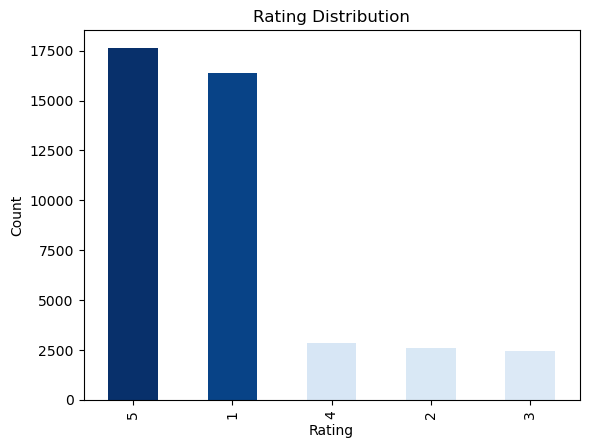

In [42]:
print("\nRating distribution:")
# Count ratings and sort descending
rating_counts = df['rating'].value_counts().sort_values(ascending=False)

# Generate colors based on counts (deeper color for higher count)
colors = plt.cm.Blues(rating_counts / rating_counts.max())

# Plot
rating_counts.plot(kind='bar', color=colors, title='Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [43]:
grouped = df.groupby(['country', 'source'])['rating']
print(pd.DataFrame({
    'mean_rating': grouped.mean(),
    'median_rating': grouped.median()
}))


                    mean_rating  median_rating
country source                                
CA      App Store      3.448980            4.0
        Play Store     3.043400            3.0
GB      App Store      3.893878            5.0
        Play Store     3.043400            3.0
NG      App Store      3.106122            3.0
        Play Store     3.043400            3.0
US      App Store      3.624490            5.0
        Play Store     3.043400            3.0


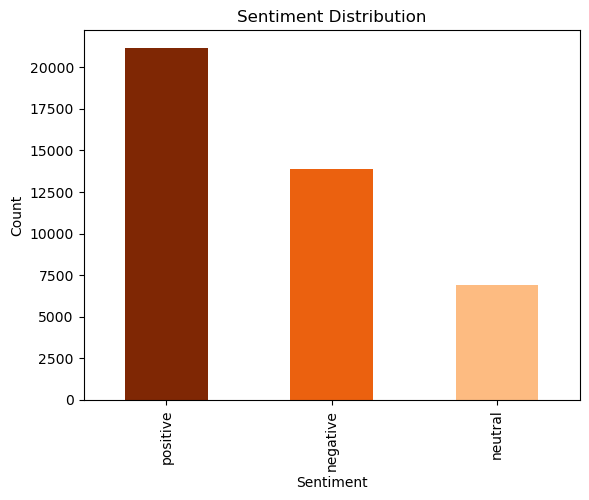

In [44]:
# Count sentiments
sentiment_counts = df['sentiment_combined'].value_counts()

# Generate colors: deeper color for higher count
colors = plt.cm.Oranges(sentiment_counts / sentiment_counts.max())

# Plot
sentiment_counts.plot(kind='bar', color=colors, title='Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [45]:
# Compare sentiment_combined vs sentiment_rating
pd.crosstab(df['sentiment_combined'], df['sentiment_rating'])



sentiment_rating,negative,neutral,positive
sentiment_combined,,,
negative,13293,582,0
neutral,5717,513,690
positive,0,1349,19816


In [46]:
# Compare sentiment_combined vs sentiment_rating
pd.crosstab(df['sentiment_combined'], df['sentiment'])


sentiment,negative,neutral,positive
sentiment_combined,,,
negative,8585,5290,0
neutral,690,513,5717
positive,0,3442,17723


In [47]:
# Sentiment by country
print("\nSentiment distribution by country:")
df.groupby('country')['sentiment_combined'].value_counts(normalize=True).unstack()



Sentiment distribution by country:


sentiment_combined,negative,neutral,positive
country,,,
CA,0.330982,0.165205,0.503813
GB,0.327455,0.163012,0.509533
NG,0.334795,0.166826,0.498379
US,0.329457,0.164633,0.505910


In [48]:
print("\nAverage VADER score by country/source:")
df.groupby('country')['vader_score'].median()



Average VADER score by country/source:


country
CA    0.29600
GB    0.31515
NG    0.29600
US    0.29600
Name: vader_score, dtype: float64

In [49]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [50]:
print("Rows failed to convert:", df['date'].isna().sum())

Rows failed to convert: 1960


In [51]:
df['date']

0       2025-09-25 10:04:52
1       2025-09-25 09:38:19
2       2025-09-25 09:35:26
3       2025-09-25 09:32:37
4       2025-09-25 09:21:38
                ...        
41955                   NaT
41956                   NaT
41957                   NaT
41958                   NaT
41959                   NaT
Name: date, Length: 41960, dtype: datetime64[ns]

In [52]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative,negative,negative
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive,positive,positive
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive,negative,neutral
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive,positive,positive
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,NaT,GB,App Store,love netflix spend half time working half time...,0.6369,positive,positive,positive
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,NaT,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive,positive,positive
41957,Strangerthings1608,This is the best streaming service with banger...,5,NaT,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive,positive,positive
41958,hugh wwe123,wwe,5,NaT,GB,App Store,wwe,0.0000,neutral,positive,positive


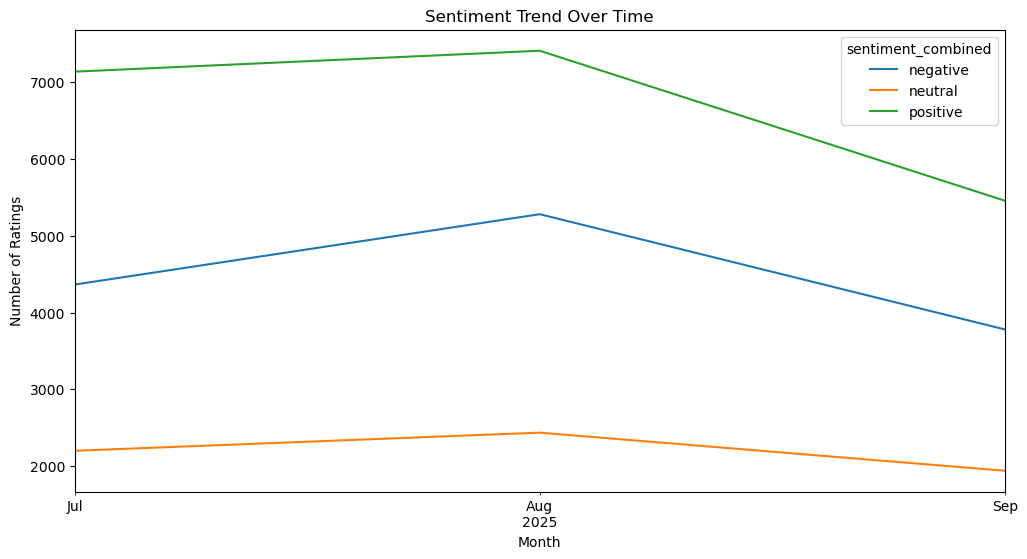

In [53]:
# Sentiment trend over time
df.set_index('date').groupby('sentiment_combined')['rating'].resample('ME').count().unstack(0).plot(title='Sentiment Trend Over Time', figsize=(12,6))
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.show()


In [54]:
# Find the earliest date
earliest_date = df['date'].min()
print("Earliest date in the dataset:", earliest_date)

Earliest date in the dataset: 2025-07-03 10:48:36


In [55]:
latest_date = df['date'].max()
print("Latest date in the dataset:", latest_date)

Latest date in the dataset: 2025-09-25 10:04:52


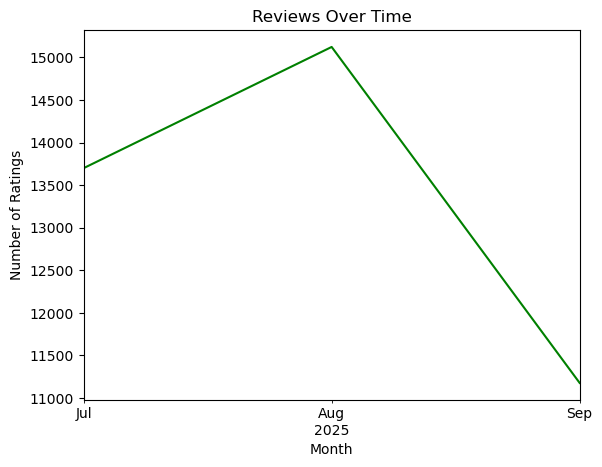

In [56]:
# Set date as index and resample by month
df.set_index('date')['rating'].resample('ME').count().plot(
    title='Reviews Over Time', color='green'
)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.show()

In [57]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative,negative,negative
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive,positive,positive
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive,negative,neutral
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive,positive,positive
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,NaT,GB,App Store,love netflix spend half time working half time...,0.6369,positive,positive,positive
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,NaT,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive,positive,positive
41957,Strangerthings1608,This is the best streaming service with banger...,5,NaT,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive,positive,positive
41958,hugh wwe123,wwe,5,NaT,GB,App Store,wwe,0.0000,neutral,positive,positive


In [58]:
print(df.columns)


Index(['username', 'review', 'rating', 'date', 'country', 'source',
       'clean_review', 'vader_score', 'sentiment', 'sentiment_rating',
       'sentiment_combined'],
      dtype='object')


In [59]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative,negative,negative
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive,positive,positive
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive,negative,neutral
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive,positive,positive
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,NaT,GB,App Store,love netflix spend half time working half time...,0.6369,positive,positive,positive
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,NaT,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive,positive,positive
41957,Strangerthings1608,This is the best streaming service with banger...,5,NaT,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive,positive,positive
41958,hugh wwe123,wwe,5,NaT,GB,App Store,wwe,0.0000,neutral,positive,positive


In [60]:
from collections import Counter
import matplotlib.pyplot as plt

In [61]:
# Most common words
all_words = ' '.join(df['clean_review'].dropna()).split()
common_words = Counter(all_words).most_common(20)
print("\nTop 20 most common words:")
print(common_words)


Top 20 most common words:
[('app', 10574), ('netflix', 10513), ('good', 6274), ('watch', 5072), ('movies', 4770), ('like', 3389), ('cant', 3270), ('love', 3245), ('shows', 2951), ('even', 2595), ('dont', 2437), ('im', 2390), ('please', 2306), ('movie', 2268), ('best', 2176), ('new', 2175), ('use', 2027), ('account', 1995), ('tv', 1985), ('great', 1945)]


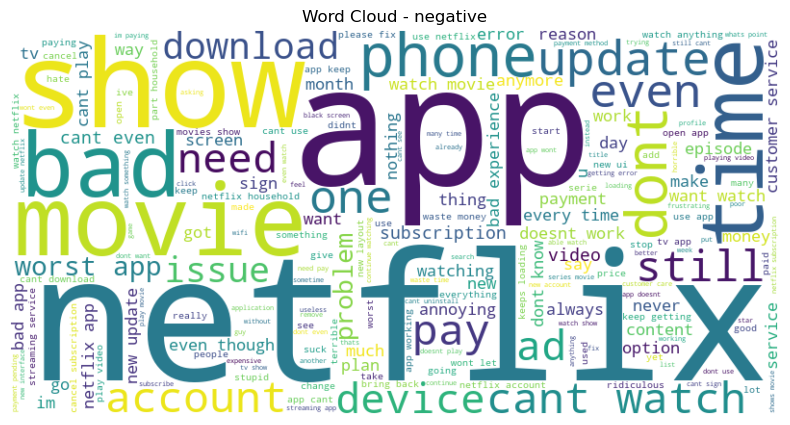

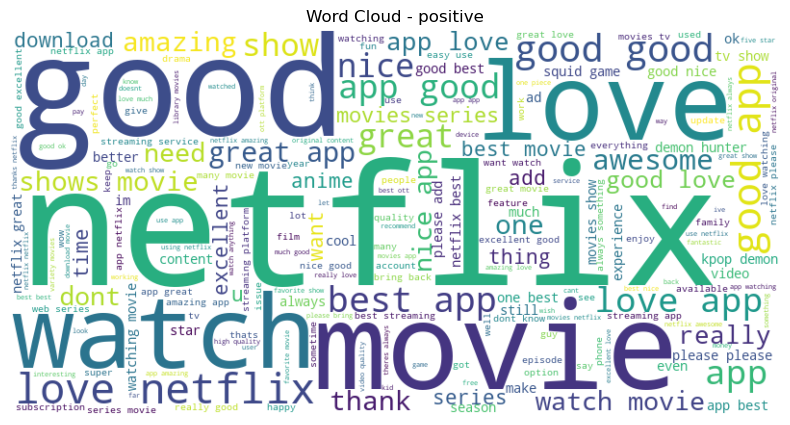

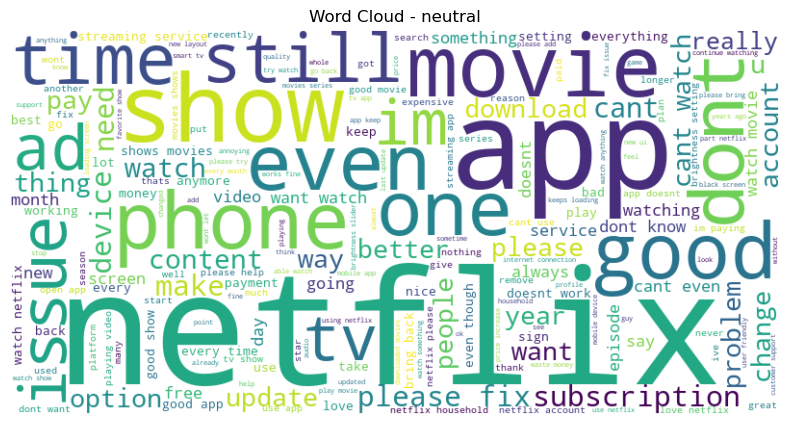

In [62]:

# Word cloud by sentiment
for sentiment in df['sentiment_combined'].unique():
    text = ' '.join(df[df['sentiment_combined']==sentiment]['clean_review'].dropna())
    if text.strip():
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - {sentiment}')
        plt.show()

In [63]:
print("\nCountry vs Source vs Sentiment:")
print(pd.crosstab([df['country'], df['source']], df['sentiment_combined'], normalize='index'))


Country vs Source vs Sentiment:
sentiment_combined  negative   neutral  positive
country source                                  
CA      App Store   0.236735  0.181633  0.581633
        Play Store  0.335600  0.164400  0.500000
GB      App Store   0.161224  0.134694  0.704082
        Play Store  0.335600  0.164400  0.500000
NG      App Store   0.318367  0.216327  0.465306
        Play Store  0.335600  0.164400  0.500000
US      App Store   0.204082  0.169388  0.626531
        Play Store  0.335600  0.164400  0.500000


In [64]:
print("\nAverage (mean) rating per sentiment class:")
print(df.groupby('sentiment_combined')['rating'].mean())

print("\nMedian rating per sentiment class:")
print(df.groupby('sentiment_combined')['rating'].median())



Average (mean) rating per sentiment class:
sentiment_combined
negative    1.195243
neutral     1.663728
positive    4.750059
Name: rating, dtype: float64

Median rating per sentiment class:
sentiment_combined
negative    1.0
neutral     1.0
positive    5.0
Name: rating, dtype: float64


In [65]:
import re

In [66]:
# detect top app features
# Combine all clean reviews
all_text = " ".join(df['clean_review'].astype(str))

# Tokenize words (remove non-alphanumeric)
words = re.findall(r'\b\w+\b', all_text.lower())

In [67]:
# remove common stopwords
stopwords = set([
    "the", "and", "is", "im", "it", "to", "for", "cant","of", "even", "dont","in", "on", "one", "get", "with", "a", "i", 
    "my", "this", "app", "movie", "movies", "show", "you", "still", "like", "want", "shows", "use", "netflix"
])
filtered_words = [w for w in words if w not in stopwords]

In [68]:
# Count top 20 keywords
top_keywords = Counter(filtered_words).most_common(20)
print("Top features/keywords users mention:")
for word, count in top_keywords:
    print(f"{word}: {count}")

Top features/keywords users mention:
good: 6274
watch: 5072
love: 3245
please: 2306
best: 2176
new: 2175
account: 1995
tv: 1985
great: 1945
time: 1910
phone: 1785
series: 1699
watching: 1684
subscription: 1655
nice: 1504
update: 1472
money: 1410
pay: 1386
content: 1383
doesnt: 1345


In [69]:
correlation = df[['vader_score', 'rating']].corr()
print("Correlation between VADER sentiment and star rating:")
print(correlation)


Correlation between VADER sentiment and star rating:
             vader_score    rating
vader_score     1.000000  0.549564
rating          0.549564  1.000000


In [70]:
# Positive text but low stars
pos_low = df[(df['vader_score'] >= 0.05) & (df['rating'] <= 2)]
print("Positive text but low star rating:")
print(pos_low[['clean_review', 'vader_score', 'rating']].head(10))

# Negative text but high stars
neg_high = df[(df['vader_score'] <= -0.05) & (df['rating'] >= 4)]
print("\nNegative text but high star rating:")
print(neg_high[['clean_review', 'vader_score', 'rating']].head(10))

Positive text but low star rating:
                                         clean_review  vader_score  rating
2                   app great pokemon horizons series       0.6249       2
12  app sooo good issue netflix games netflix tell...       0.4404       1
16  netflix refused grant permission discontinued ...       0.6486       1
34  removing grizzlies add indian horse make ts ap...       0.6597       1
43  matter image quality rubbish ive checked im su...       0.6808       2
48  please look lenovo tab extreme running latest ...       0.4019       1
53  please add movies like terminator jump street ...       0.7650       1
54  happened netflix series movies loading app fin...       0.0516       1
56  turn auto play dont want every single thing sc...       0.7564       1
61  straight away canceled netflix whole rest worl...       0.3818       1

Negative text but high star rating:
                                          clean_review  vader_score  rating
22   whoever top area web a

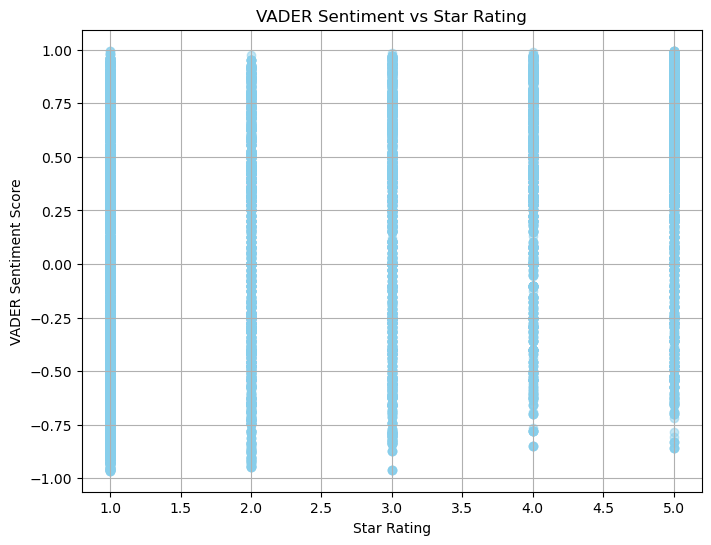

In [71]:
# 1️⃣ Scatter plot of VADER sentiment vs star rating
plt.figure(figsize=(8,6))
plt.scatter(df['rating'], df['vader_score'], alpha=0.5, color='skyblue')
plt.title('VADER Sentiment vs Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('VADER Sentiment Score')
plt.grid(True)
plt.show()

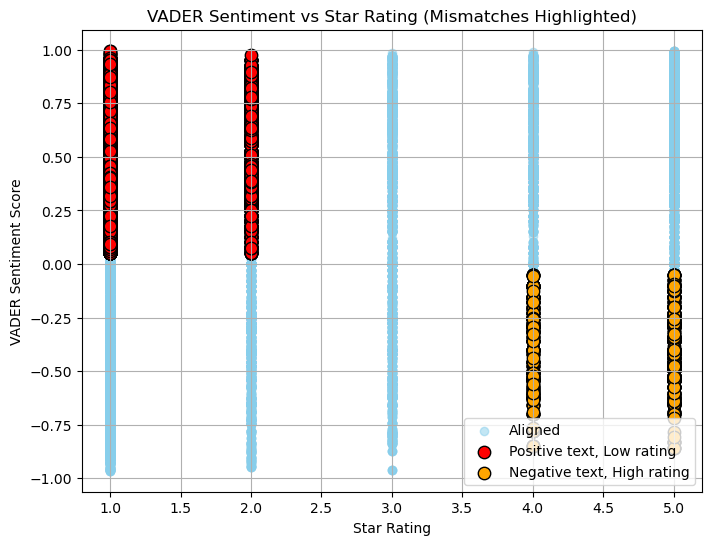

In [72]:
import matplotlib.pyplot as plt

# Define mismatch conditions
positive_text_low_rating = (df['vader_score'] >= 0.05) & (df['rating'] <= 2)
negative_text_high_rating = (df['vader_score'] <= -0.05) & (df['rating'] >= 4)

# Base scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df['rating'], df['vader_score'], alpha=0.5, color='skyblue', label='Aligned')

# Highlight mismatches
plt.scatter(df.loc[positive_text_low_rating, 'rating'],
            df.loc[positive_text_low_rating, 'vader_score'],
            color='red', edgecolor='black', s=80, label='Positive text, Low rating')

plt.scatter(df.loc[negative_text_high_rating, 'rating'],
            df.loc[negative_text_high_rating, 'vader_score'],
            color='orange', edgecolor='black', s=80, label='Negative text, High rating')

plt.title('VADER Sentiment vs Star Rating (Mismatches Highlighted)')
plt.xlabel('Star Rating')
plt.ylabel('VADER Sentiment Score')
plt.grid(True)
plt.legend()
plt.show()



In [73]:
# Example thresholds
mismatch_reviews = df[
    ((df['vader_score'] >= 0.05) & (df['rating'] <= 2)) |   # Positive text but low rating
    ((df['vader_score'] <= -0.05) & (df['rating'] >= 4))     # Negative text but high rating
]

print(f"Number of mismatched reviews: {len(mismatch_reviews)}")
print(mismatch_reviews[['username', 'clean_review', 'rating', 'vader_score']].head(10))

Number of mismatched reviews: 6407
                    username  \
2                Zev Cantero   
12             Jyothi Alikya   
16            sunday ifeanyi   
22  Frisky Frog (Fathertree)   
34               Kayden Bear   
43          Sebastian Gorgon   
48                     Reven   
53                 LA Lakers   
54                     EN GI   
56             Travis Faught   

                                         clean_review  rating  vader_score  
2                   app great pokemon horizons series       2       0.6249  
12  app sooo good issue netflix games netflix tell...       1       0.4404  
16  netflix refused grant permission discontinued ...       1       0.6486  
22  whoever top area web ad messed put k pop st al...       4      -0.2075  
34  removing grizzlies add indian horse make ts ap...       1       0.6597  
43  matter image quality rubbish ive checked im su...       2       0.6808  
48  please look lenovo tab extreme running latest ...       1       0.401

In [74]:
# Optional: show top 10 mismatched reviews
mismatch_reviews = df[positive_text_low_rating | negative_text_high_rating]
print(f"Number of mismatched reviews: {len(mismatch_reviews)}")
print(mismatch_reviews[['username', 'review', 'rating', 'vader_score']].head(10))

Number of mismatched reviews: 6407
                    username  \
2                Zev Cantero   
12             Jyothi Alikya   
16            sunday ifeanyi   
22  Frisky Frog (Fathertree)   
34               Kayden Bear   
43          Sebastian Gorgon   
48                     Reven   
53                 LA Lakers   
54                     EN GI   
56             Travis Faught   

                                               review  rating  vader_score  
2   The app is great but, pokemon horizons: the se...       2       0.6249  
12  This app is sooo good but i have an issue from...       1       0.4404  
16  netflix refused to grant me the permission to ...       1       0.6486  
22  whoever did the top 10 in your area web ad, me...       4      -0.2075  
34  their removing grizzlies they should add India...       1       0.6597  
43  no matter what the image quality is rubbish, I...       2       0.6808  
48  Please Look into why on a Lenovo tab extreme r...       1       0.401

In [75]:
!pip install scikit-learn


In [76]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Choose which column to analyze
text_column = 'clean_review'

# Initialize CountVectorizer
vectorizer = CountVectorizer(
    stop_words='english',  # remove common stopwords
    max_features=50,       # top 50 terms
    ngram_range=(1,2)      # unigrams + bigrams
)

# Fit-transform for all reviews
X = vectorizer.fit_transform(df[text_column].fillna(''))

# Create a DataFrame of terms and frequencies
term_freq = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'frequency': X.sum(axis=0).A1})
term_freq = term_freq.sort_values(by='frequency', ascending=False)
print("Top 50 terms in all reviews:")
print(term_freq)

# Optional: Extract keywords per sentiment class
for sentiment in df['sentiment_combined'].unique():
    reviews_subset = df[df['sentiment_combined'] == sentiment][text_column].fillna('')
    X_sub = vectorizer.fit_transform(reviews_subset)
    term_freq_sub = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'frequency': X_sub.sum(axis=0).A1})
    term_freq_sub = term_freq_sub.sort_values(by='frequency', ascending=False)
    print(f"\nTop terms for {sentiment} reviews:")
    print(term_freq_sub.head(10))


Top 50 terms in all reviews:
            term  frequency
3            app      10574
25       netflix      10513
13          good       6274
46         watch       5072
23        movies       4770
18          like       3389
19          love       3245
37         shows       2951
10          dont       2437
15            im       2390
22         movie       2268
5           best       2176
26           new       2175
43           use       2027
0        account       1995
41            tv       1985
14         great       1945
40          time       1910
30         phone       1785
45          want       1722
35        series       1699
47      watching       1684
39  subscription       1655
27          nice       1504
42        update       1472
21         money       1410
28           pay       1386
7        content       1383
9         doesnt       1345
33        really       1335
38     streaming       1278
4            bad       1267
11      download       1228
12           fix   

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Use the cleaned reviews column
texts = df['clean_review'].dropna().astype(str)

# Initialize TF-IDF
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')  # top 50 words
tfidf_matrix = vectorizer.fit_transform(texts)

# Convert to DataFrame for readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Get top keywords by average importance
top_keywords = tfidf_df.mean().sort_values(ascending=False).head(20)
print("Top Keywords in Reviews:")
print(top_keywords)


Top Keywords in Reviews:
good       0.104998
app        0.104228
netflix    0.084949
love       0.047183
movies     0.046685
watch      0.046503
best       0.034066
like       0.033173
great      0.030054
nice       0.029816
shows      0.028381
movie      0.026661
dont       0.024802
new        0.023427
im         0.022426
use        0.021766
account    0.021656
time       0.020965
tv         0.020915
bad        0.019583
dtype: float64


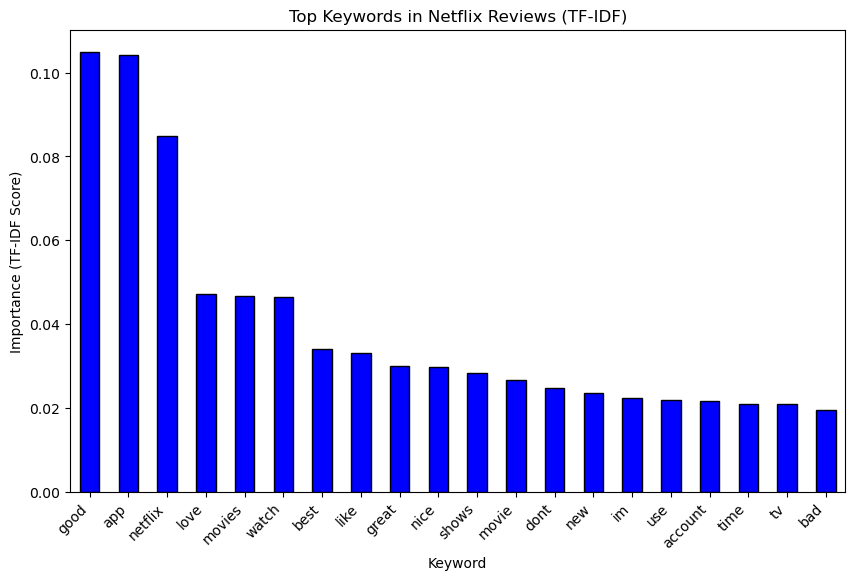

In [78]:
import matplotlib.pyplot as plt

# --- TF-IDF Keyword Extraction ---
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Use the cleaned reviews column
texts = df['clean_review'].dropna().astype(str)

# Initialize TF-IDF
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')  # top 50 words
tfidf_matrix = vectorizer.fit_transform(texts)

# Convert to DataFrame for readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Get top keywords by average importance
top_keywords = tfidf_df.mean().sort_values(ascending=False).head(20)

# --- Visualization ---
plt.figure(figsize=(10,6))
top_keywords.plot(kind='bar', color='blue', edgecolor='black')
plt.title("Top Keywords in Netflix Reviews (TF-IDF)")
plt.xlabel("Keyword")
plt.ylabel("Importance (TF-IDF Score)")
plt.xticks(rotation=45, ha="right")
plt.show()


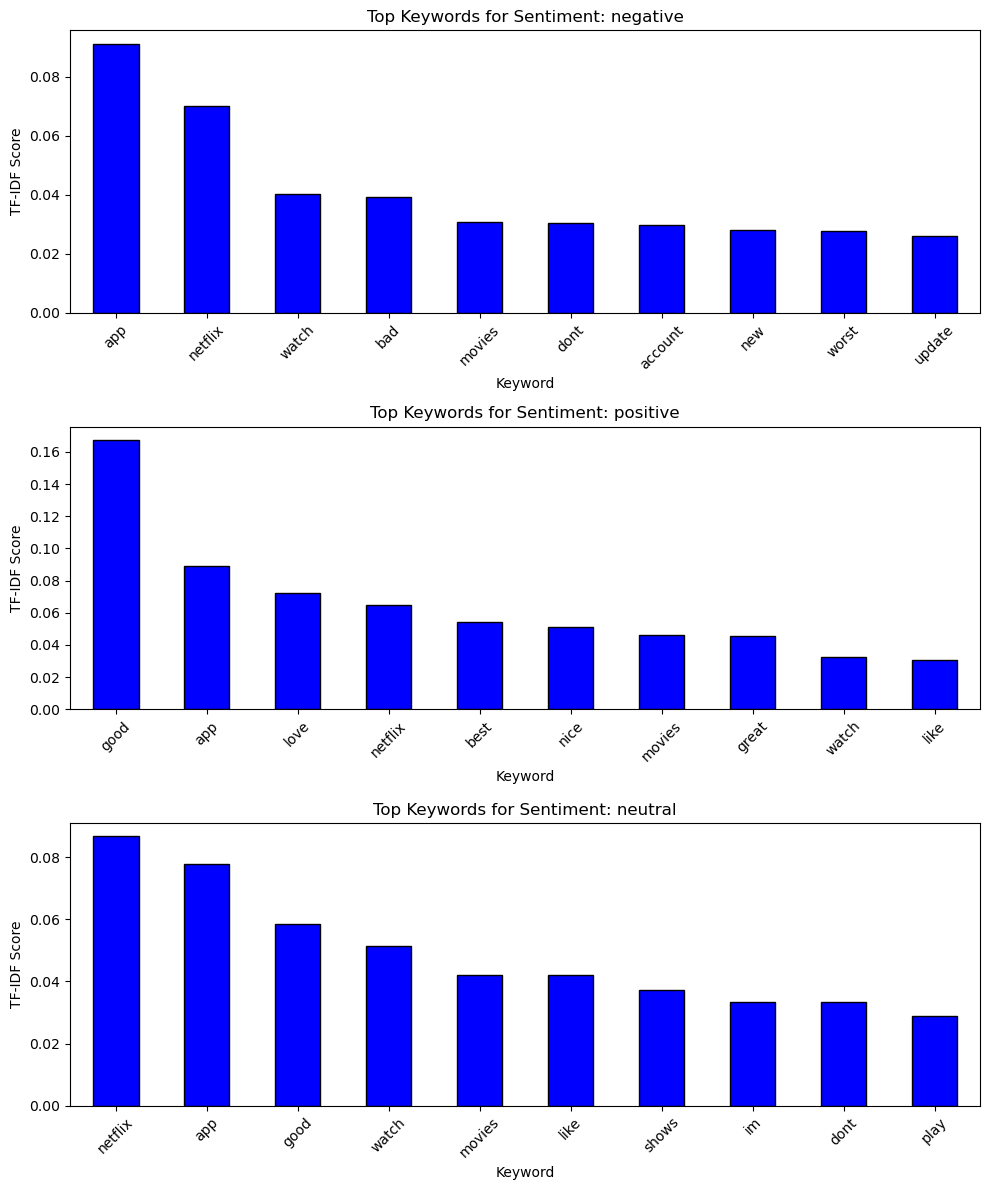

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_keywords_by_sentiment(df, sentiment_col='sentiment_combined', text_col='clean_review', n=10):
    results = {}

    for sentiment in df[sentiment_col].unique():
        # Subset reviews for that sentiment
        subset = df[df[sentiment_col] == sentiment][text_col].dropna().astype(str)

        if subset.empty:
            continue

        # TF-IDF
        vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(subset)
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

        # Top n words
        top_keywords = tfidf_df.mean().sort_values(ascending=False).head(n)
        results[sentiment] = top_keywords

    return results


# Run the function
sentiment_keywords = get_top_keywords_by_sentiment(df, n=10)

# --- Visualization ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(sentiment_keywords), 1, figsize=(10, 12))

for ax, (sentiment, keywords) in zip(axes, sentiment_keywords.items()):
    keywords.plot(kind='bar', ax=ax, color='blue', edgecolor='black')
    ax.set_title(f"Top Keywords for Sentiment: {sentiment}")
    ax.set_xlabel("Keyword")
    ax.set_ylabel("TF-IDF Score")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [80]:
# Define mismatch rules
def detect_mismatches(row):
    if row['sentiment_combined'] == 'positive' and row['rating'] <= 2:
        return "Positive text but low rating"
    elif row['sentiment_combined'] == 'negative' and row['rating'] >= 4:
        return "Negative text but high rating"
    else:
        return None

df['mismatch'] = df.apply(detect_mismatches, axis=1)

# View mismatched examples
mismatches = df[df['mismatch'].notnull()][['clean_review', 'rating', 'vader_score', 'sentiment_combined', 'mismatch']]

print("Number of mismatched reviews:", len(mismatches))
mismatches.head(10)


Number of mismatched reviews: 0


,clean_review,rating,vader_score,sentiment_combined,mismatch


In [81]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined,mismatch
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative,negative,negative,None
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive,positive,positive,None
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive,negative,neutral,None
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive,positive,positive,None
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive,positive,positive,None
...,...,...,...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,NaT,GB,App Store,love netflix spend half time working half time...,0.6369,positive,positive,positive,None
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,NaT,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive,positive,positive,None
41957,Strangerthings1608,This is the best streaming service with banger...,5,NaT,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive,positive,positive,None
41958,hugh wwe123,wwe,5,NaT,GB,App Store,wwe,0.0000,neutral,positive,positive,None


In [82]:
def detect_mismatches(row):
    # Positive text but low rating (1–2 stars)
    if row['sentiment_combined'] == 'positive' and row['rating'] <= 2:
        return "Positive text but low rating"
    
    # Negative text but high rating (4–5 stars)
    elif row['sentiment_combined'] == 'negative' and row['rating'] >= 4:
        return "Negative text but high rating"
    
    # Neutral text but extreme rating (1 or 5 stars)
    elif row['sentiment_combined'] == 'neutral' and (row['rating'] == 1 or row['rating'] == 5):
        return "Neutral text but extreme rating"
    
    else:
        return None


# Apply mismatch detection
df['mismatch'] = df.apply(detect_mismatches, axis=1)

# Filter mismatched rows
mismatches = df[df['mismatch'].notnull()][
    ['clean_review', 'rating', 'vader_score', 'sentiment_combined', 'mismatch']
]

print("Number of mismatched reviews:", len(mismatches))
mismatches.head(10)


Number of mismatched reviews: 5060


,clean_review,rating,vader_score,sentiment_combined,mismatch
12,app sooo good issue netflix games netflix tell...,1,0.4404,neutral,Neutral text but extreme rating
16,netflix refused grant permission discontinued ...,1,0.6486,neutral,Neutral text but extreme rating
34,removing grizzlies add indian horse make ts ap...,1,0.6597,neutral,Neutral text but extreme rating
48,please look lenovo tab extreme running latest ...,1,0.4019,neutral,Neutral text but extreme rating
53,please add movies like terminator jump street ...,1,0.7650,neutral,Neutral text but extreme rating
54,happened netflix series movies loading app fin...,1,0.0516,neutral,Neutral text but extreme rating
56,turn auto play dont want every single thing sc...,1,0.7564,neutral,Neutral text but extreme rating
61,straight away canceled netflix whole rest worl...,1,0.3818,neutral,Neutral text but extreme rating
71,good,1,0.4404,neutral,Neutral text but extreme rating
100,theres nothing netflix platform provides bette...,1,0.6597,neutral,Neutral text but extreme rating


In [83]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined,mismatch
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative,negative,negative,None
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive,positive,positive,None
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive,negative,neutral,None
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive,positive,positive,None
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive,positive,positive,None
...,...,...,...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,NaT,GB,App Store,love netflix spend half time working half time...,0.6369,positive,positive,positive,None
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,NaT,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive,positive,positive,None
41957,Strangerthings1608,This is the best streaming service with banger...,5,NaT,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive,positive,positive,None
41958,hugh wwe123,wwe,5,NaT,GB,App Store,wwe,0.0000,neutral,positive,positive,None


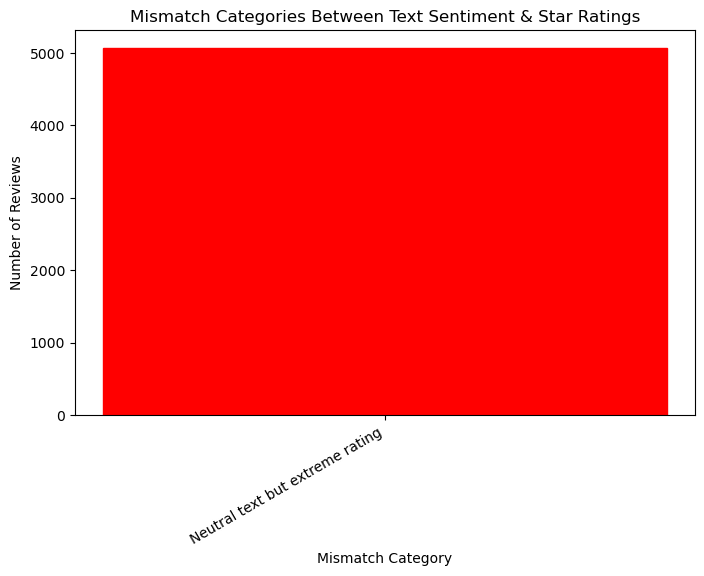

In [84]:
import matplotlib.pyplot as plt

# Count mismatches by category
mismatch_counts = df['mismatch'].value_counts()

# Plot bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(mismatch_counts.index, mismatch_counts.values, color='orange', edgecolor='black')

# Highlight the largest mismatch with deeper color
bars[mismatch_counts.values.argmax()].set_color('red')

plt.title("Mismatch Categories Between Text Sentiment & Star Ratings")
plt.xlabel("Mismatch Category")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=30, ha='right')
plt.show()


In [85]:
# Show 3 sample reviews from each mismatch category
for category in df['mismatch'].dropna().unique():
    print(f"\n--- {category.upper()} ---")
    sample_reviews = df[df['mismatch'] == category].sample(10, random_state=42)
    for i, row in sample_reviews.iterrows():
        print(f"User: {row['username']}, Rating: {row['rating']}, Sentiment: {row['sentiment_combined']}")
        print(f"Review: {row['clean_review'][:200]}...")  # limit to 200 chars
        print("-" * 50)



--- NEUTRAL TEXT BUT EXTREME RATING ---
User: Nhlelo Baloyi, Rating: 5, Sentiment: neutral
Review: streaming quality bad like p quality...
--------------------------------------------------
User: Josh Hardes, Rating: 1, Sentiment: neutral
Review: app busted android last months intermittent success even loading let alone watching anything...
--------------------------------------------------
User: Saul Delgado, Rating: 1, Sentiment: neutral
Review: alot alot experience much fun...
--------------------------------------------------
User: ric flair, Rating: 1, Sentiment: neutral
Review: im using netflix plan streaming unable stream mobile updated application reinstalled doesnt work worst application ever used...
--------------------------------------------------
User: Eugene Tolentino, Rating: 1, Sentiment: neutral
Review: definitely netflix doesnt value customers continual increasing prices changing plan options means loyalty customers never problem platform implemented netflix househol

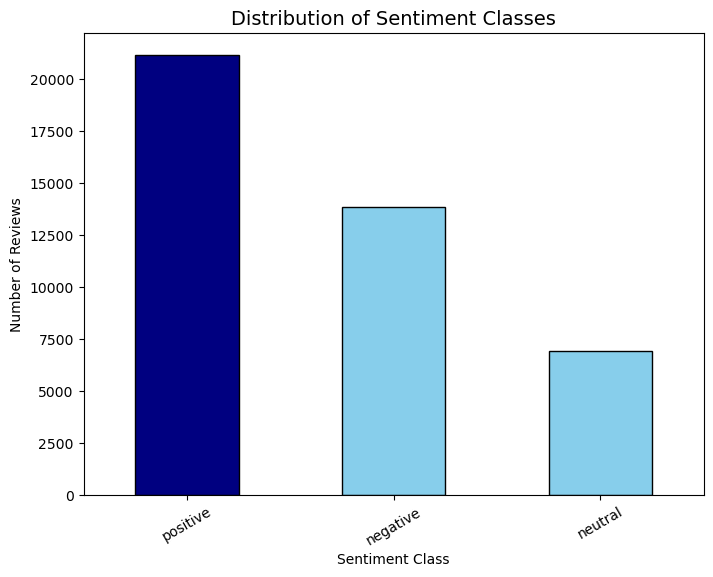

Sentiment counts:
sentiment_combined
positive    21165
negative    13875
neutral      6920
Name: count, dtype: int64


In [86]:
import matplotlib.pyplot as plt

# Count sentiment categories
sent_counts = df['sentiment_combined'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,6))
bars = sent_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Highlight the most frequent sentiment with a deeper color
bars.patches[0].set_facecolor('navy')

plt.title("Distribution of Sentiment Classes", fontsize=14)
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=30)
plt.show()

print("Sentiment counts:")
print(sent_counts)


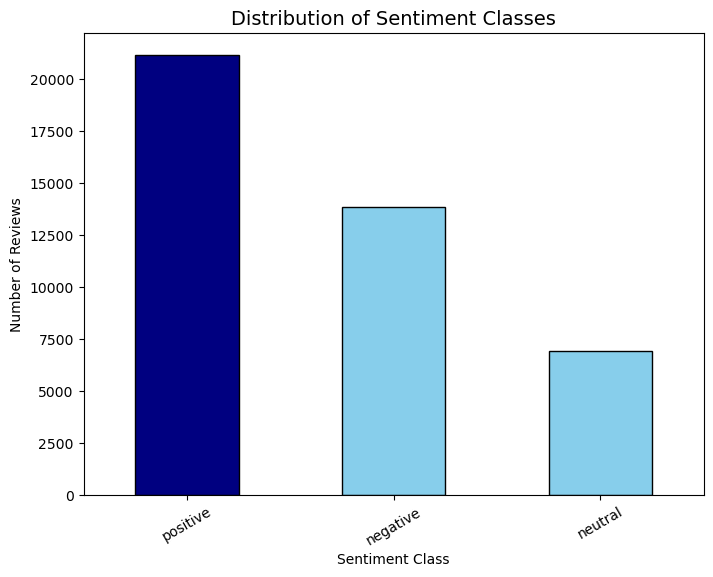

Sentiment distribution (counts & percentages):
                    Count  Percentage (%)
sentiment_combined                       
positive            21165           50.44
negative            13875           33.07
neutral              6920           16.49


In [87]:
import matplotlib.pyplot as plt

# Count sentiment categories
sent_counts = df['sentiment_combined'].value_counts().sort_values(ascending=False)

# Convert to percentage
sent_percent = (sent_counts / len(df)) * 100

# Plot
plt.figure(figsize=(8,6))
bars = sent_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Highlight the most frequent sentiment with a deeper color
bars.patches[0].set_facecolor('navy')

plt.title("Distribution of Sentiment Classes", fontsize=14)
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=30)
plt.show()

# Display counts and percentages
sent_dist = pd.DataFrame({
    "Count": sent_counts,
    "Percentage (%)": sent_percent.round(2)
})

print("Sentiment distribution (counts & percentages):")
print(sent_dist)


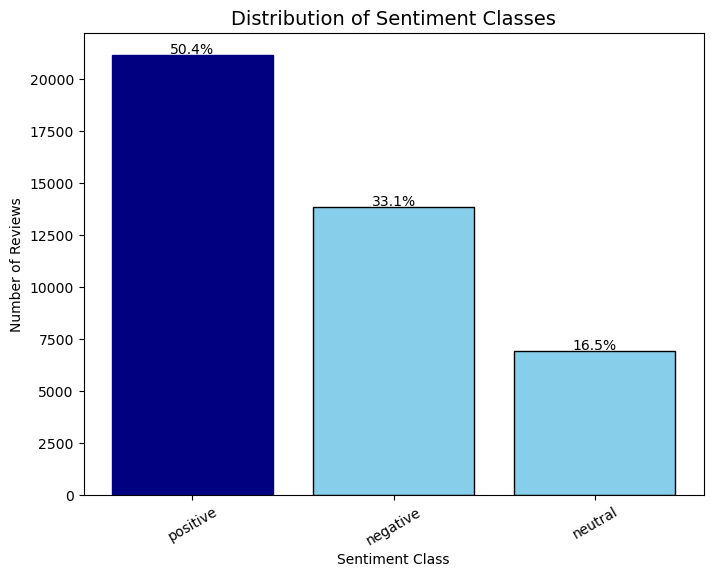

In [88]:
import matplotlib.pyplot as plt

# Count and percentage
sent_counts = df['sentiment_combined'].value_counts().sort_values(ascending=False)
sent_percent = (sent_counts / len(df)) * 100

plt.figure(figsize=(8,6))
bars = plt.bar(sent_counts.index, sent_counts.values, color='skyblue', edgecolor='black')

# Highlight the top sentiment with deeper color
bars[0].set_color('navy')

# Add percentages above bars
for bar, pct in zip(bars, sent_percent):
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position
        bar.get_height() + 50,             # y position (slightly above bar)
        f"{pct:.1f}%",                     # percentage label
        ha='center', fontsize=10, color='black'
    )

plt.title("Distribution of Sentiment Classes", fontsize=14)
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=30)
plt.show()


In [89]:
import pandas as pd

# Class distribution
sent_counts = df['sentiment_combined'].value_counts()
sent_percent = (sent_counts / len(df)) * 100

dist_df = pd.DataFrame({
    'Count': sent_counts,
    'Percentage': sent_percent.round(2)
})

print("📊 Sentiment Class Distribution:")
print(dist_df)

# Simple imbalance check
max_pct = sent_percent.max()
min_pct = sent_percent.min()
imbalance_ratio = max_pct / min_pct if min_pct > 0 else float('inf')

print("\nImbalance Ratio (largest/smallest class):", round(imbalance_ratio, 2))

if imbalance_ratio > 3:
    print("⚠️ Dataset is highly imbalanced — could affect ML performance.")
elif imbalance_ratio > 1.5:
    print("⚠️ Moderate imbalance — may need balancing techniques (SMOTE, class weights, etc.).")
else:
    print("✅ Classes are fairly balanced.")


📊 Sentiment Class Distribution:
                    Count  Percentage
sentiment_combined                   
positive            21165       50.44
negative            13875       33.07
neutral              6920       16.49

Imbalance Ratio (largest/smallest class): 3.06
⚠️ Dataset is highly imbalanced — could affect ML performance.


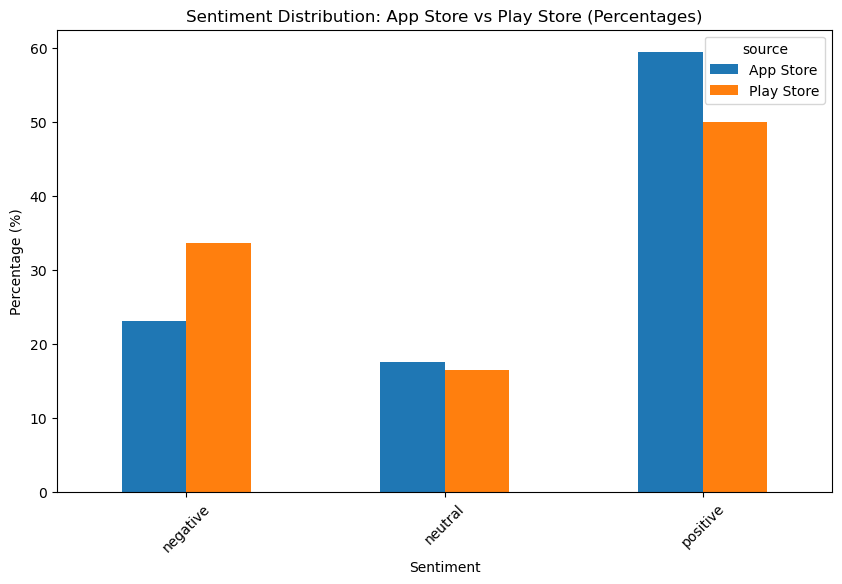

In [90]:
import matplotlib.pyplot as plt

# Sentiment distribution per platform
sentiment_source = df.groupby(['source', 'sentiment_combined']).size().unstack(fill_value=0)

# Normalize to percentage
sentiment_source_pct = sentiment_source.div(sentiment_source.sum(axis=1), axis=0) * 100

# Plot
sentiment_source_pct.T.plot(kind='bar', figsize=(10,6))
plt.title("Sentiment Distribution: App Store vs Play Store (Percentages)")
plt.ylabel("Percentage (%)")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.legend(title="source")
plt.show()


In [91]:
df

,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined,mismatch
0,Timothy Glykis,"Cancelled my subscription, but i still get cha...",1,2025-09-25 10:04:52,NG,Play Store,cancelled subscription still get charged,-0.4215,negative,negative,negative,None
1,Hasan Gujamo,Good episode,5,2025-09-25 09:38:19,NG,Play Store,good episode,0.4404,positive,positive,positive,None
2,Zev Cantero,"The app is great but, pokemon horizons: the se...",2,2025-09-25 09:35:26,NG,Play Store,app great pokemon horizons series,0.6249,positive,negative,neutral,None
3,Makhan Rabidas,good,5,2025-09-25 09:32:37,NG,Play Store,good,0.4404,positive,positive,positive,None
4,Savita Kasde,nice,5,2025-09-25 09:21:38,NG,Play Store,nice,0.4215,positive,positive,positive,None
...,...,...,...,...,...,...,...,...,...,...,...,...
41955,showdoe,"I love Netflix. I spend half my time working, ...",5,NaT,GB,App Store,love netflix spend half time working half time...,0.6369,positive,positive,positive,None
41956,dontthinkiknowaname,This app is so help full and easy to access it...,5,NaT,GB,App Store,app help full easy access lot favourite shows ...,0.6808,positive,positive,positive,None
41957,Strangerthings1608,This is the best streaming service with banger...,5,NaT,GB,App Store,best streaming service bangers like stranger t...,0.8481,positive,positive,positive,None
41958,hugh wwe123,wwe,5,NaT,GB,App Store,wwe,0.0000,neutral,positive,positive,None


In [92]:
def top_ngrams(corpus, ngram_range=(2,2), n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

for sentiment in df['sentiment_combined'].unique():
    subset = df[df['sentiment_combined'] == sentiment]['clean_review'].astype(str)
    print(f"\nTop bigrams for {sentiment}:")
    print(top_ngrams(subset, (2,2), 10))
    print(f"Top trigrams for {sentiment}:")
    print(top_ngrams(subset, (3,3), 10))



Top bigrams for negative:
[('worst app', np.int64(262)), ('doesnt work', np.int64(210)), ('dont know', np.int64(155)), ('customer service', np.int64(151)), ('want watch', np.int64(150)), ('wont let', np.int64(138)), ('netflix app', np.int64(137)), ('watch netflix', np.int64(129)), ('bad experience', np.int64(128)), ('new update', np.int64(125))]
Top trigrams for negative:
[('problem playing video', np.int64(40)), ('wont let watch', np.int64(30)), ('app doesnt work', np.int64(24)), ('kpop demon hunters', np.int64(22)), ('dont like new', np.int64(21)), ('new ui tv', np.int64(20)), ('app working properly', np.int64(20)), ('app isnt working', np.int64(20)), ('worst streaming service', np.int64(20)), ('shows payment pending', np.int64(20))]

Top bigrams for positive:
[('love netflix', np.int64(652)), ('good app', np.int64(501)), ('best app', np.int64(475)), ('love app', np.int64(441)), ('great app', np.int64(288)), ('shows movies', np.int64(286)), ('nice app', np.int64(238)), ('movies seri

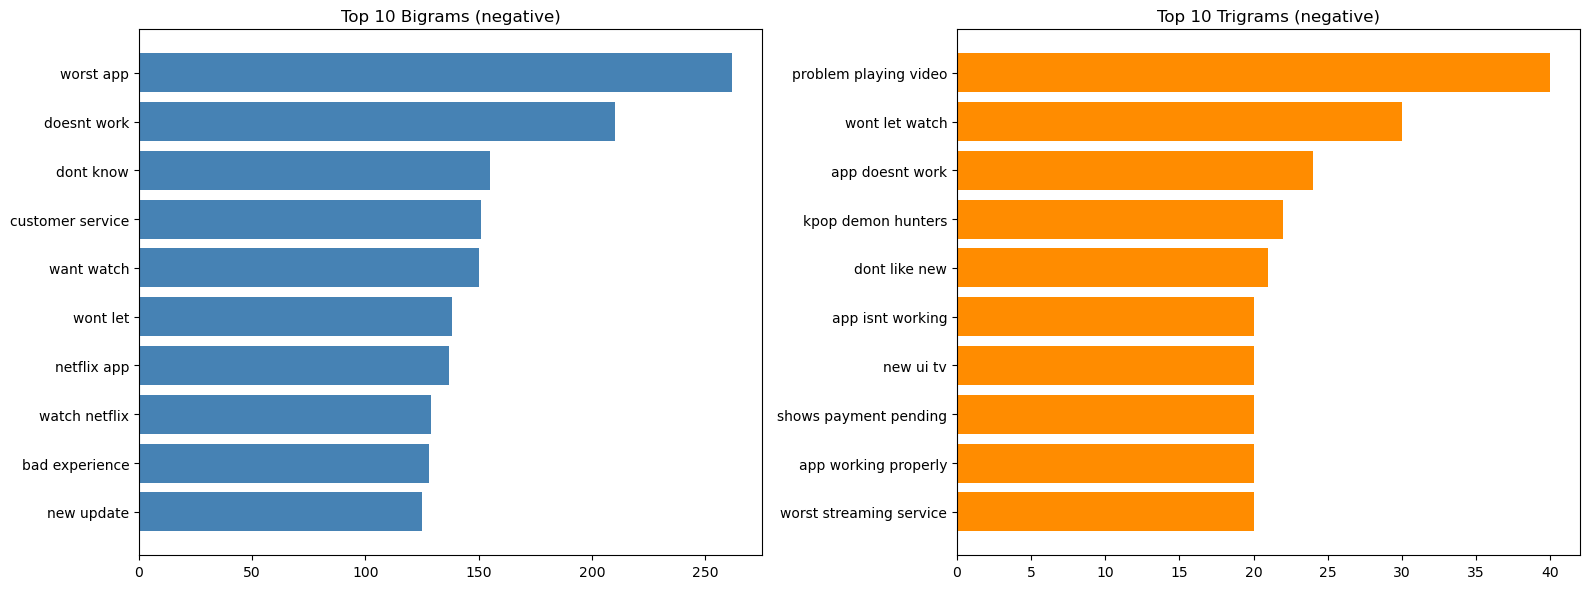

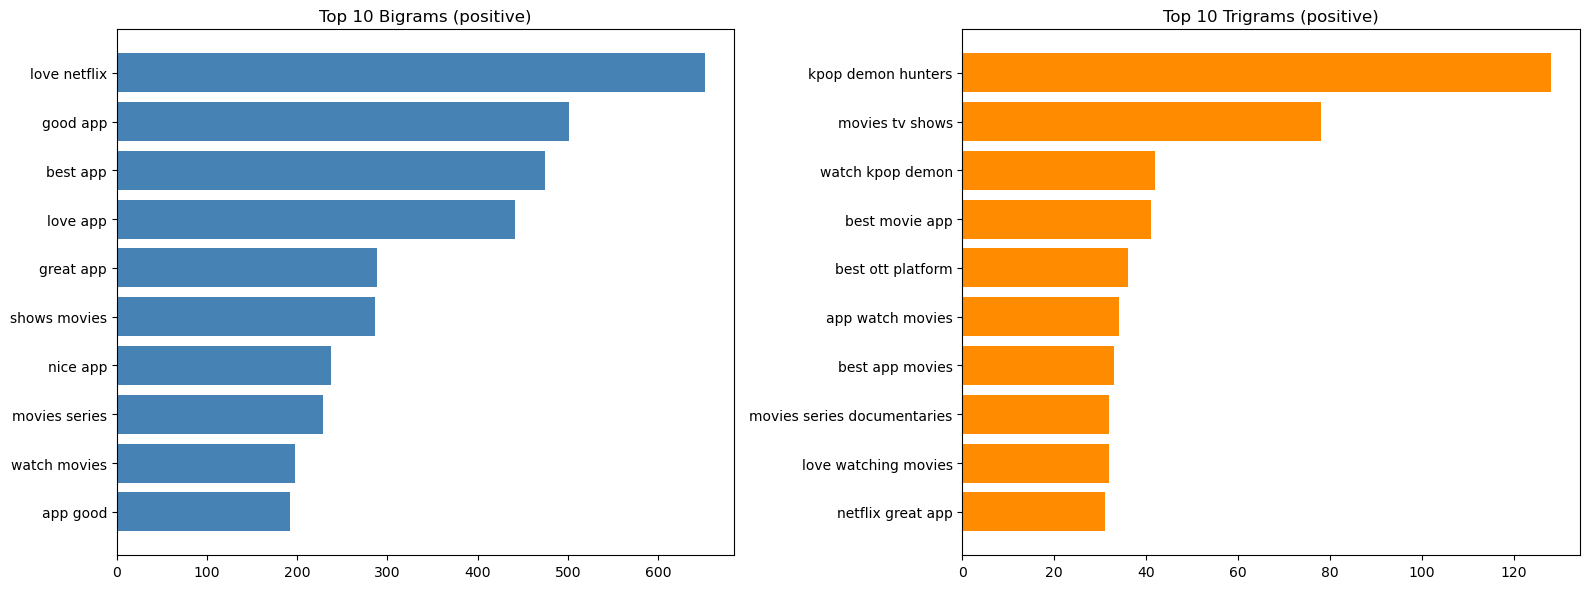

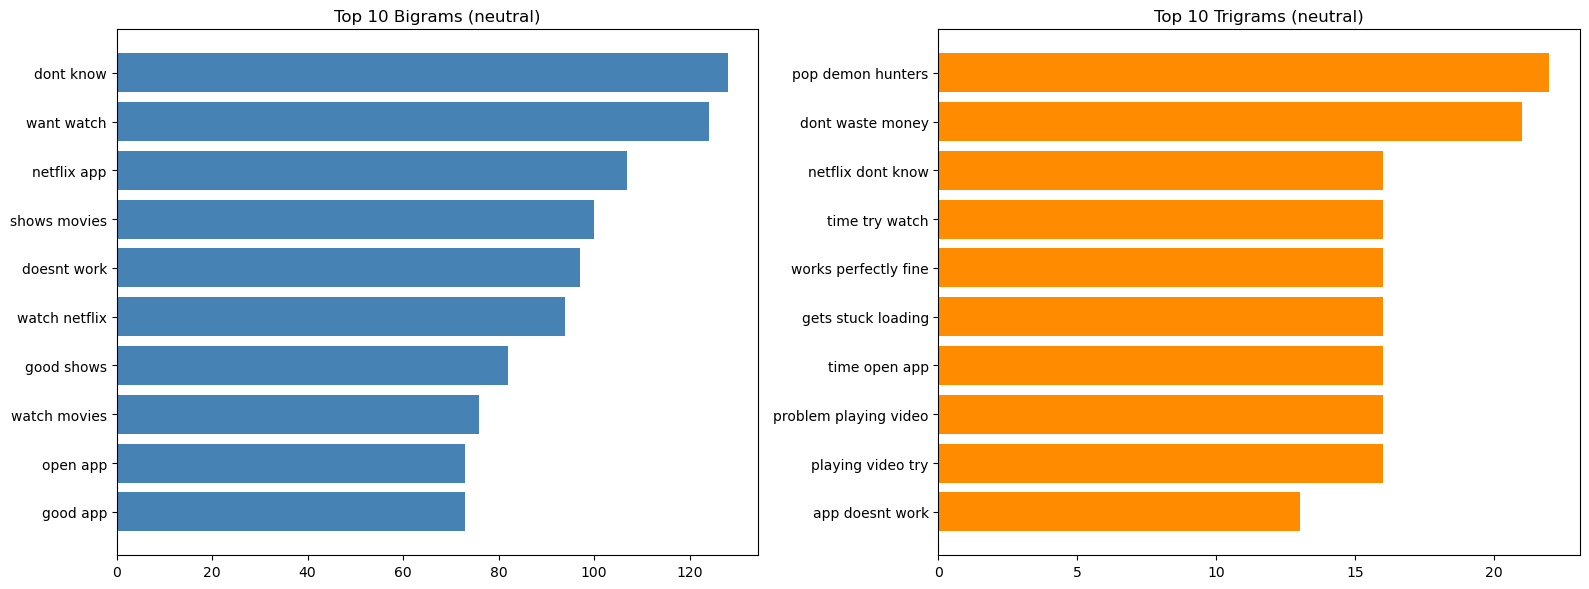

In [93]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

def plot_bigrams_trigrams(df, sentiment_label, top_n=10):
    # Filter reviews by sentiment
    reviews = df[df['sentiment_combined'] == sentiment_label]['clean_review']

    if reviews.empty:
        print(f"No reviews found for sentiment: {sentiment_label}")
        return

    # Bigrams
    vectorizer_bi = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    bi_matrix = vectorizer_bi.fit_transform(reviews)
    bi_counts = bi_matrix.sum(axis=0).A1
    bigram_freq = pd.DataFrame({
        'ngram': vectorizer_bi.get_feature_names_out(),
        'count': bi_counts
    }).sort_values(by='count', ascending=False).head(top_n)

    # Trigrams
    vectorizer_tri = CountVectorizer(ngram_range=(3, 3), stop_words='english')
    tri_matrix = vectorizer_tri.fit_transform(reviews)
    tri_counts = tri_matrix.sum(axis=0).A1
    trigram_freq = pd.DataFrame({
        'ngram': vectorizer_tri.get_feature_names_out(),
        'count': tri_counts
    }).sort_values(by='count', ascending=False).head(top_n)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    
    axes[0].barh(bigram_freq['ngram'], bigram_freq['count'], color="steelblue")
    axes[0].set_title(f"Top {top_n} Bigrams ({sentiment_label})")
    axes[0].invert_yaxis()
    
    axes[1].barh(trigram_freq['ngram'], trigram_freq['count'], color="darkorange")
    axes[1].set_title(f"Top {top_n} Trigrams ({sentiment_label})")
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Run for all sentiment classes
for sentiment in df['sentiment_combined'].unique():
    plot_bigrams_trigrams(df, sentiment, top_n=10)



In [94]:
df['sentiment_combined'].value_counts()


sentiment_combined
positive    21165
negative    13875
neutral      6920
Name: count, dtype: int64

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [96]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [97]:
# 1. Split data into features and labels
X = df[['clean_review']]               # your review text
y = df['sentiment_combined']   # 5 sentiment classes


In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [99]:
# 1. Vectorize training text
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train['clean_review'])
X_test_tfidf = tfidf.transform(X_test['clean_review'])

In [100]:
from sklearn.pipeline import Pipeline


In [101]:
from imblearn.over_sampling import SMOTE


In [104]:

# 4. Create a pipeline: TF-IDF + Multinomial Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', MultinomialNB(class_prior=[0.33, 0.33, 0.34]))  # example priors
])


In [105]:

# 5. Train the model
pipeline_nb.fit(X_train['clean_review'], y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [107]:
# 6. Make predictions
y_pred_nb = pipeline_nb.predict(X_test['clean_review'])

In [108]:
# 7. Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.85      0.85      2775
     neutral       0.64      0.70      0.67      1384
    positive       0.92      0.88      0.90      4233

    accuracy                           0.84      8392
   macro avg       0.80      0.81      0.81      8392
weighted avg       0.85      0.84      0.85      8392

Confusion Matrix:
 [[2366  242  167]
 [ 243  972  169]
 [ 171  316 3746]]


Classification Report (weighted):

              precision    recall  f1-score   support

    negative     0.8511    0.8526    0.8518      2775
     neutral     0.6353    0.7023    0.6671      1384
    positive     0.9177    0.8850    0.9010      4233

    accuracy                         0.8441      8392
   macro avg     0.8014    0.8133    0.8067      8392
weighted avg     0.8491    0.8441    0.8462      8392



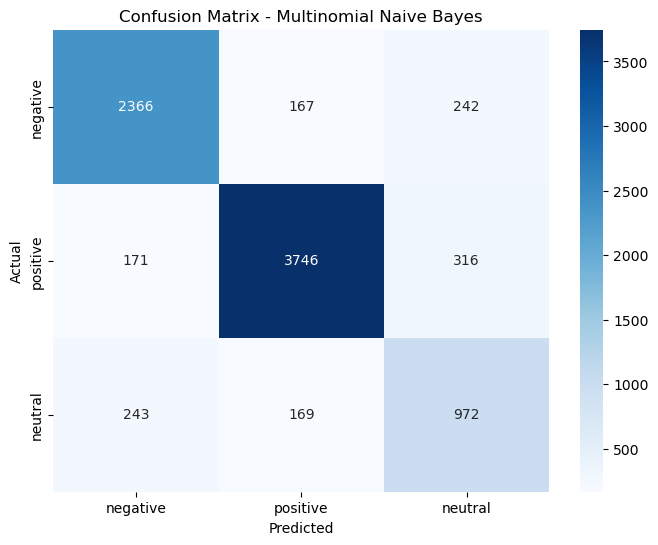

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Weighted metrics
print("Classification Report (weighted):\n")
print(classification_report(y_test, y_pred_nb, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb, labels=df['sentiment_combined'].unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df['sentiment_combined'].unique(),
            yticklabels=df['sentiment_combined'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()


In [110]:
# 1. Imports

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd

In [111]:

# 2. Split data
X = df[['clean_review']]
y = df['sentiment_combined']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [112]:
# 1. Vectorize training text
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train['clean_review'])
X_test_tfidf = tfidf.transform(X_test['clean_review'])

In [113]:
# 3. Create pipeline
pipeline_svc = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(class_weight='balanced', max_iter=5000))
])

In [114]:
# 4. Train model
pipeline_svc.fit(X_train['clean_review'], y_train)


,steps,"[('tfidf', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [115]:
# 5. Predictions
y_pred_svc = pipeline_svc.predict(X_test['clean_review'])

In [116]:
# 6. Evaluate
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))

              precision    recall  f1-score   support

    negative       0.94      0.94      0.94      2775
     neutral       0.73      0.89      0.80      1384
    positive       0.97      0.90      0.94      4233

    accuracy                           0.91      8392
   macro avg       0.88      0.91      0.89      8392
weighted avg       0.92      0.91      0.92      8392

[[2618  127   30]
 [  76 1232   76]
 [  80  333 3820]]


In [117]:
from sklearn.model_selection import GridSearchCV

# 1. Define parameter grid
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10],  # regularization parameter for LinearSVC
}


In [118]:
# 2. Setup GridSearch
grid = GridSearchCV(pipeline_svc, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)

In [119]:
# 3. Train with GridSearch
grid.fit(X_train['clean_review'], y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


,estimator,Pipeline(step..._iter=5000))])
,param_grid,"{'clf__C': [0.1, 1, ...], 'tfidf__max_features': [5000, 10000], 'tfidf__ngram_range': [(1, ...), (1, ...)]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [122]:
# 4. Best parameters
print("Best parameters:", grid.best_params_)


Best parameters: {'clf__C': 10, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


In [123]:
# 5. Predictions on test
y_pred_svc_grid = grid.predict(X_test['clean_review'])

In [124]:
# 6. Evaluation
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_svc_grid))
print(confusion_matrix(y_test, y_pred_svc_grid))

              precision    recall  f1-score   support

    negative       0.97      0.96      0.96      2775
     neutral       0.76      0.92      0.83      1384
    positive       0.98      0.92      0.94      4233

    accuracy                           0.93      8392
   macro avg       0.90      0.93      0.91      8392
weighted avg       0.94      0.93      0.93      8392

[[2651  100   24]
 [  44 1269   71]
 [  49  308 3876]]


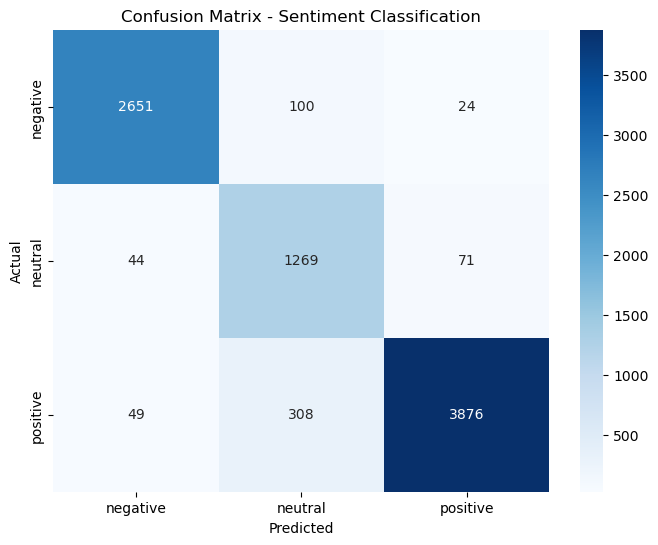

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svc_grid, labels=grid.classes_)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=grid.classes_, yticklabels=grid.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Sentiment Classification')
plt.show()


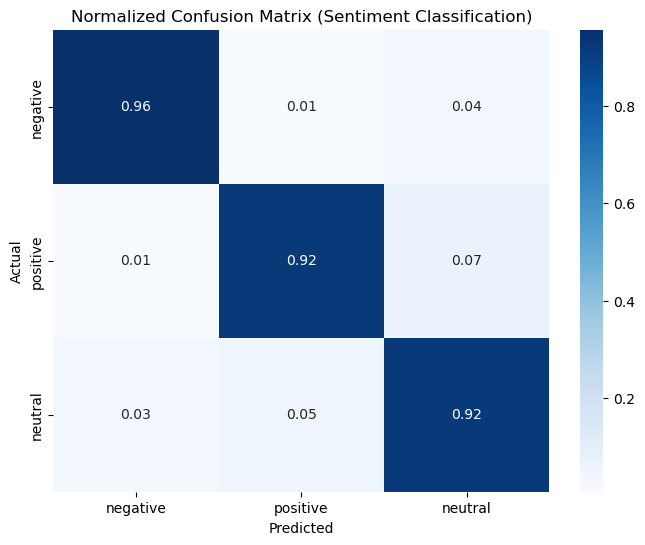

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# True and predicted labels
y_true = y_test  # replace with your actual test labels
y_pred = y_pred_svc_grid  # replace with your predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'positive', 'neutral'])

# Normalize
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, None]

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=['negative', 'positive', 'neutral'],
            yticklabels=['negative', 'positive', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix (Sentiment Classification)')
plt.show()


In [129]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler


In [130]:
# Assuming your dataframe is `df` and target is 'sentiment_combined'
X = df[['clean_review']]
y = df['sentiment_combined']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [131]:
# 1. Vectorize training text
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train['clean_review'])
X_test_tfidf = tfidf.transform(X_test['clean_review'])

In [132]:
from sklearn.ensemble import RandomForestClassifier


In [133]:
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

In [134]:
# Train
pipeline_rf.fit(X_train['clean_review'], y_train)


,steps,"[('tfidf', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [135]:
# Predict
y_pred_rf = pipeline_rf.predict(X_test['clean_review'])


In [136]:
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

    negative       0.96      0.96      0.96      2775
     neutral       0.97      0.91      0.94      1384
    positive       0.96      0.98      0.97      4233

    accuracy                           0.96      8392
   macro avg       0.96      0.95      0.96      8392
weighted avg       0.96      0.96      0.96      8392

[[2676    9   90]
 [  51 1259   74]
 [  57   33 4143]]


In [137]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


In [138]:
# Assuming your dataframe is `df` and target is 'sentiment_combined'
X = df[['clean_review']]
y = df['sentiment_combined']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [139]:
# 1. Vectorize training text
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train['clean_review'])
X_test_tfidf = tfidf.transform(X_test['clean_review'])

In [140]:
# Create SVM pipeline
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('svm', SVC(kernel='linear', class_weight='balanced', random_state=42))
])


In [141]:
# Train on balanced training data
pipeline_svm.fit(X_train['clean_review'], y_train)


,steps,"[('tfidf', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [142]:
 # Predict on test
y_pred_svm = pipeline_svm.predict(X_test['clean_review'])

In [143]:
# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.93      0.92      2775
     neutral       0.81      0.86      0.83      1384
    positive       0.96      0.92      0.94      4233

    accuracy                           0.91      8392
   macro avg       0.89      0.90      0.90      8392
weighted avg       0.92      0.91      0.91      8392

Confusion Matrix:
[[2567  112   96]
 [ 110 1196   78]
 [ 152  176 3905]]


In [144]:
from sklearn.linear_model import LogisticRegression

In [145]:
X = df[['clean_review']]
y = df['sentiment_combined']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [146]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train['clean_review'])
X_test_tfidf = tfidf.transform(X_test['clean_review'])

In [147]:
# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42))
])


In [148]:
# Train
pipeline_lr.fit(X_train['clean_review'], y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [149]:
# Predict
y_pred_lr = pipeline_lr.predict(X_test['clean_review'])


In [150]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Confusion Matrix:
 [[2526  153   96]
 [ 125 1166   93]
 [ 175  263 3795]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.91      0.90      2775
     neutral       0.74      0.84      0.79      1384
    positive       0.95      0.90      0.92      4233

    accuracy                           0.89      8392
   macro avg       0.86      0.88      0.87      8392
weighted avg       0.90      0.89      0.89      8392



In [151]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [152]:
# Dictionary of predictions
model_preds = {
    "MultinomialNB": y_pred_nb,
    "LinearSVC_SMOTE": y_pred_svc_grid,
    "RandomForest": y_pred_rf,
    "SVM": y_pred_svm,
    "LogisticRegression": y_pred_lr
}


In [153]:
# Store results
results = {}

for name, y_pred in model_preds.items():
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        "Accuracy": acc,
        "F1 Macro": f1_macro,
        "F1 Weighted": f1_weighted,
        "Classification Report": classification_report(y_test, y_pred, digits=3),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

In [154]:

summary_df = pd.DataFrame({
    model: {
        "Accuracy": metrics["Accuracy"],
        "F1 Macro": metrics["F1 Macro"],
        "F1 Weighted": metrics["F1 Weighted"]
    }
    for model, metrics in results.items()
}).T

print("\n=== Model Comparison Summary ===")
print(summary_df)


=== Model Comparison Summary ===
                    Accuracy  F1 Macro  F1 Weighted
MultinomialNB       0.844137  0.806664     0.846187
LinearSVC_SMOTE     0.928980  0.911576     0.931030
RandomForest        0.962583  0.956941     0.962427
SVM                 0.913727  0.896589     0.914432
LogisticRegression  0.892159  0.870640     0.893847


In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the summary dataframe for plotting
summary_melted = summary_df.reset_index().melt(
    id_vars="index", var_name="Metric", value_name="Score"
)
summary_melted.rename(columns={"index": "Model"}, inplace=True)


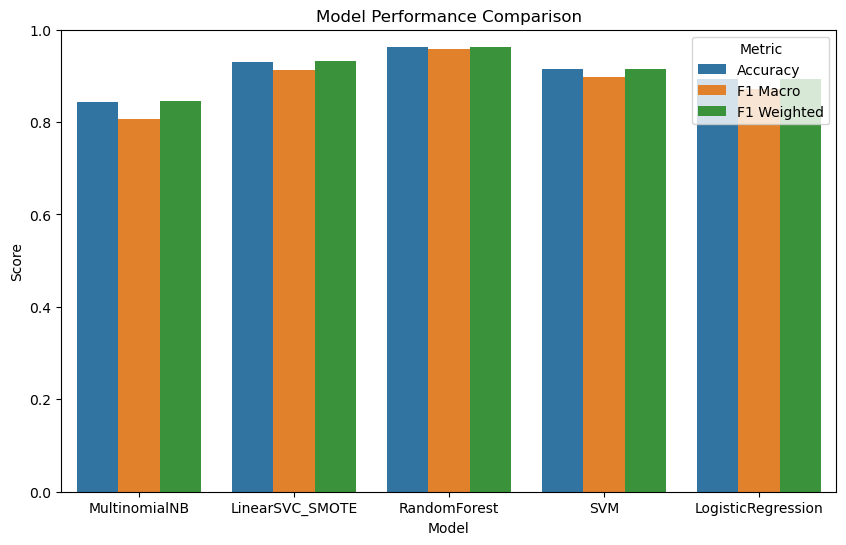

In [156]:
 # Plot grouped bar chart
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Score", hue="Metric", data=summary_melted)
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.show()


In [157]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

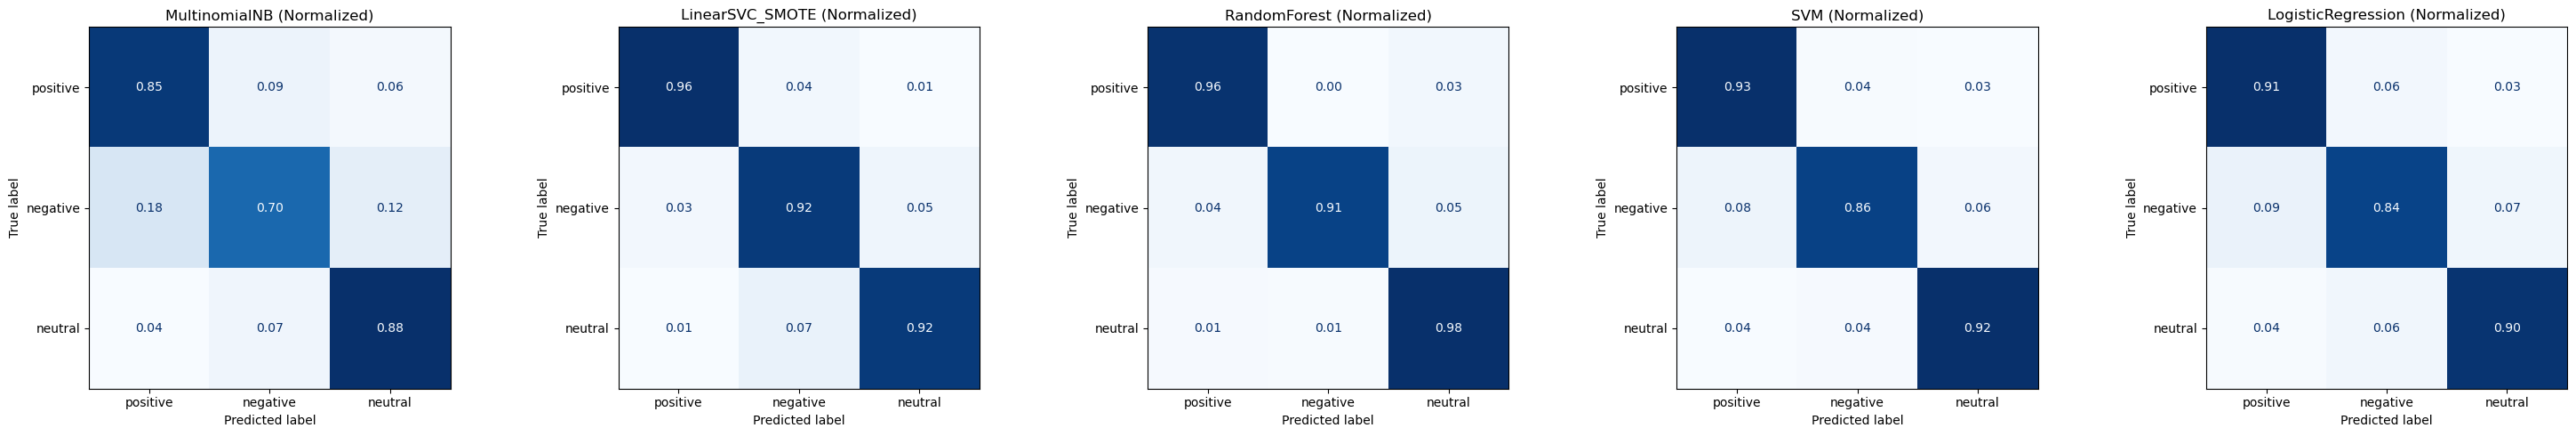

In [158]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Number of models
n_models = len(results)

# Create subplots
fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5))

for ax, (name, metrics) in zip(axes, results.items()):
    cm = metrics["Confusion Matrix"].astype(float)

    # Normalize by row (true labels)
    cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=y_test.unique())
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format=".2f")
    ax.set_title(f"{name} (Normalized)", fontsize=12)

plt.tight_layout()
plt.show()

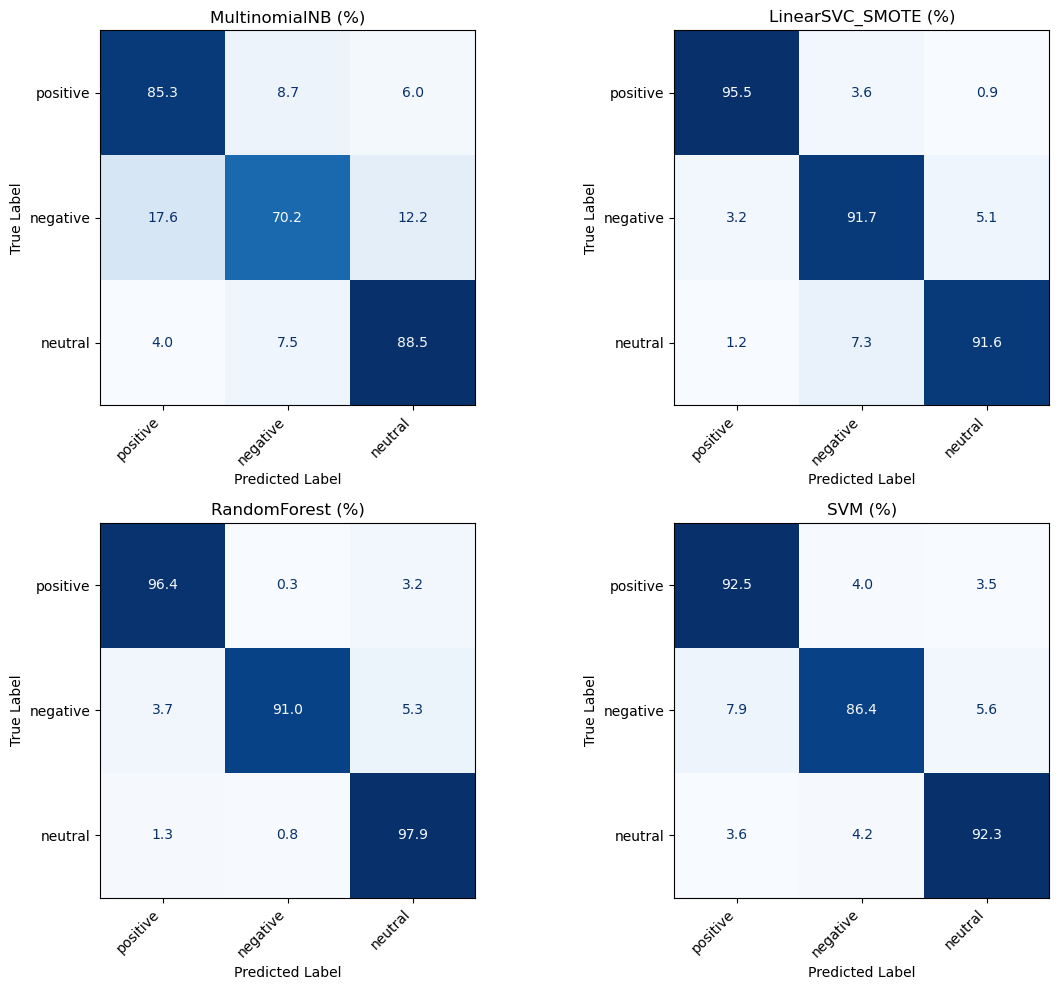

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 2x2 grid for 4 models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, metrics) in zip(axes, results.items()):
    cm = metrics["Confusion Matrix"].astype(float)
    
    # Normalize by row (true labels) and convert to percentages
    cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis] * 100  

    # Plot normalized matrix (percentages)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                  display_labels=y_test.unique())
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format=".1f")  
    
    ax.set_title(f"{name} (%)", fontsize=12)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust layout
plt.tight_layout()
plt.show()

In [160]:
from sklearn.model_selection import cross_val_score

# Dictionary of models (not predictions now, but actual trained pipelines)
model_objects = {
    "MultinomialNB": pipeline_nb,
    "LinearSVC_SMOTE": pipeline_svc,   # trained with SMOTE data
    "RandomForest": pipeline_rf,
    "SVM": pipeline_svm,
    "LogisticRegression": pipeline_lr
    
}

In [161]:
# Store results with CV
cv_results = {}

for name, model in model_objects.items():
    print(f"Running cross-validation for {name}...")
    
    # Cross-validation (5-fold)
    scores = cross_val_score(model, X_train['clean_review'], y_train, cv=5, scoring='accuracy')
    
    cv_results[name] = {
        "CV Mean Accuracy": scores.mean(),
        "CV Std Accuracy": scores.std()
    }

# Convert to dataframe
cv_df = pd.DataFrame(cv_results).T

Running cross-validation for MultinomialNB...
Running cross-validation for LinearSVC_SMOTE...
Running cross-validation for RandomForest...
Running cross-validation for SVM...
Running cross-validation for LogisticRegression...


In [162]:
# Merge with your earlier summary_df (test results)
comparison_df = summary_df.merge(cv_df, left_index=True, right_index=True)

print("\n=== Final Model Comparison (Test + Cross-Validation) ===")
print(comparison_df)


=== Final Model Comparison (Test + Cross-Validation) ===
                    Accuracy  F1 Macro  F1 Weighted  CV Mean Accuracy  \
MultinomialNB       0.844137  0.806664     0.846187          0.842886   
LinearSVC_SMOTE     0.928980  0.911576     0.931030          0.901990   
RandomForest        0.962583  0.956941     0.962427          0.952991   
SVM                 0.913727  0.896589     0.914432          0.898415   
LogisticRegression  0.892159  0.870640     0.893847          0.884503   

                    CV Std Accuracy  
MultinomialNB              0.007328  
LinearSVC_SMOTE            0.005338  
RandomForest               0.003084  
SVM                        0.006408  
LogisticRegression         0.005012  


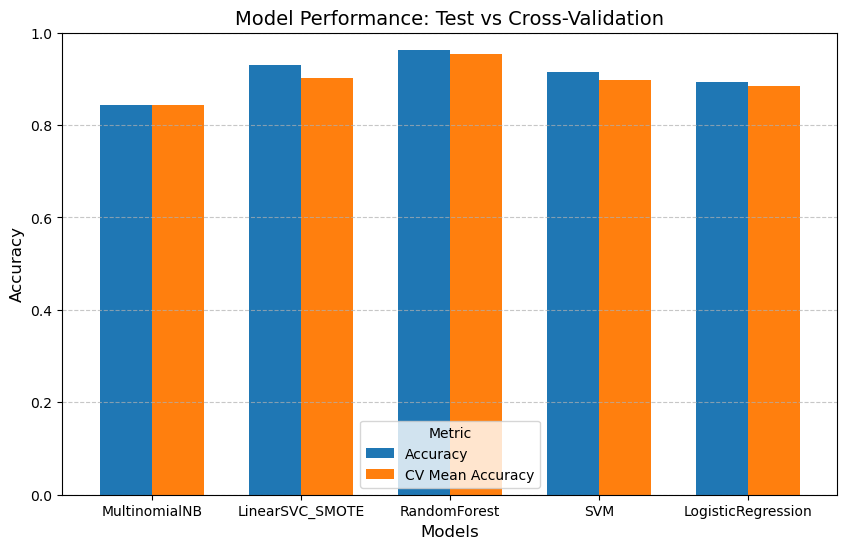

In [163]:
import matplotlib.pyplot as plt

# Select only relevant columns for plotting
plot_df = comparison_df[["Accuracy", "CV Mean Accuracy"]]

# Plot grouped bar chart
ax = plot_df.plot(kind="bar", figsize=(10,6), width=0.7)

plt.title("Model Performance: Test vs Cross-Validation", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.ylim(0, 1)  # since accuracy is between 0 and 1
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

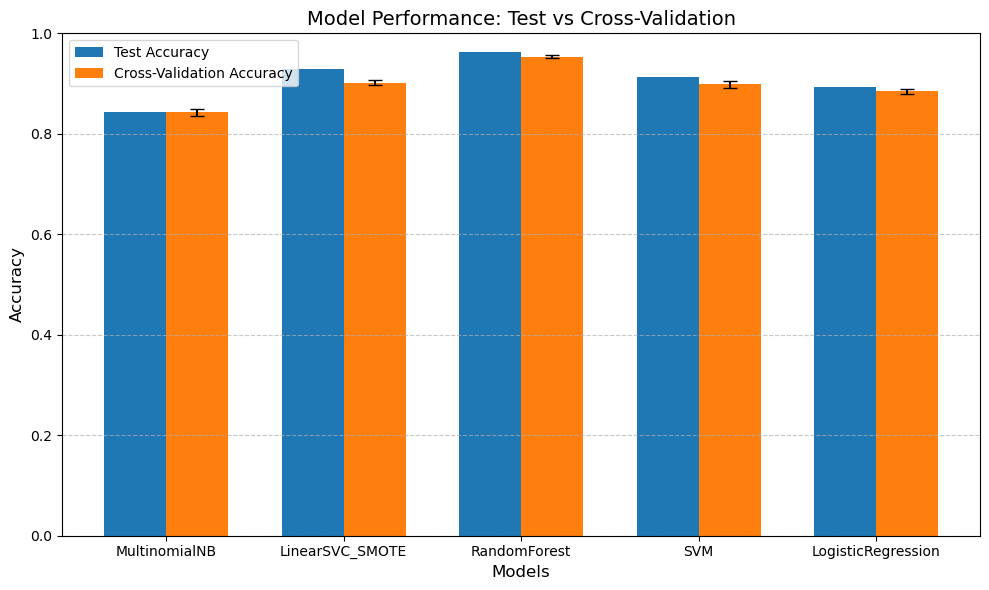

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = comparison_df.index
x = np.arange(len(models))  # model positions
width = 0.35  # bar width

# Plot bars
fig, ax = plt.subplots(figsize=(10,6))

# Test accuracy bars
rects1 = ax.bar(x - width/2, comparison_df["Accuracy"], width, label="Test Accuracy")

# CV accuracy bars with error bars
rects2 = ax.bar(
    x + width/2,
    comparison_df["CV Mean Accuracy"],
    width,
    yerr=comparison_df["CV Std Accuracy"],  # error bars
    capsize=5,
    label="Cross-Validation Accuracy"
)

# Titles and labels
ax.set_title("Model Performance: Test vs Cross-Validation", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_xlabel("Models", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [167]:
# Loop through all models and show misclassified examples
for name, y_pred in model_preds.items():
    print(f"\n=== Sample Misclassified Reviews ({name}) ===")
    
    # Build error dataframe
    errors = X_test.copy()
    errors = errors  # ensure it's a DataFrame
    errors["True"] = y_test.values
    errors["Predicted"] = y_pred
    
    # Keep only misclassified
    errors = errors[errors["True"] != errors["Predicted"]]
    
    if errors.empty:
        print("No misclassifications for this model.")
        continue
    
    # Show some random errors
    for i, row in errors.sample(min(5, len(errors)), random_state=42).iterrows():
        print(f"Review: {row['clean_review']}")
        print(f"True Label: {row['True']} | Predicted: {row['Predicted']}")
        print("-"*80)



=== Sample Misclassified Reviews (MultinomialNB) ===
Review: couldnt cancel subscription app website
True Label: positive | Predicted: negative
--------------------------------------------------------------------------------
Review: wish ads long instead money bro like secs every end episode mins movies like plzzzzzzzzzz ill rate
True Label: neutral | Predicted: positive
--------------------------------------------------------------------------------
Review: plan experience know sure paying premium plan app still seeing ads live going informed canceling month
True Label: neutral | Predicted: negative
--------------------------------------------------------------------------------
Review: using netflix first time
True Label: positive | Predicted: negative
--------------------------------------------------------------------------------
Review: watching netflix sudennly wouldnt let watch shows like naruto etc please fix bug glitch update fixes everything somethings even tried unninstal r

In [174]:
# Side-by-side error comparison for all models
comparison_df = X_test.copy()
comparison_df = comparison_df  # ensure DataFrame
comparison_df["True"] = y_test.values

# Add predictions from each model
for name, y_pred in model_preds.items():
    comparison_df[name] = y_pred

# Keep only rows where at least one model was wrong
errors_all = comparison_df[
    (comparison_df["True"] != comparison_df["MultinomialNB"]) |
    (comparison_df["True"] != comparison_df["LinearSVC_SMOTE"]) |
    (comparison_df["True"] != comparison_df["RandomForest"]) |
    (comparison_df["True"] != comparison_df["SVM"]) |
    (comparison_df["True"] != comparison_df["LogisticRegression"])
]

# Show a few random samples
for i, row in errors_all.sample(min(10, len(errors_all)), random_state=42).iterrows():
    print(f"\nReview: {row['clean_review']}")
    print(f"True Label: {row['True']}")
    print(f"MultinomialNB: {row['MultinomialNB']}")
    print(f"LinearSVC_SMOTE: {row['LinearSVC_SMOTE']}")
    print(f"RandomForest: {row['RandomForest']}")
    print(f"SVM: {row['SVM']}")
    print(f"LogisticRegression: {row['LogisticRegression']}")
    print("-"*100)



Review: hello dear bought new gift card want pay
True Label: positive
MultinomialNB: neutral
LinearSVC_SMOTE: positive
RandomForest: positive
SVM: positive
LogisticRegression: neutral
----------------------------------------------------------------------------------------------------

Review: premium
True Label: positive
MultinomialNB: negative
LinearSVC_SMOTE: positive
RandomForest: positive
SVM: positive
LogisticRegression: positive
----------------------------------------------------------------------------------------------------

Review: glitchs
True Label: negative
MultinomialNB: positive
LinearSVC_SMOTE: neutral
RandomForest: positive
SVM: positive
LogisticRegression: positive
----------------------------------------------------------------------------------------------------

Review: watching netflix sudennly wouldnt let watch shows like naruto etc please fix bug glitch update fixes everything somethings even tried unninstal reinstall worke h leave netflix want watch show pls 

In [176]:
# Side-by-side error comparison with ✅ and ❌
comparison_df = X_test.copy()
comparison_df = comparison_df  # ensure DataFrame
comparison_df["True"] = y_test.values

# Add predictions from each model
for name, y_pred in model_preds.items():
    comparison_df[name] = y_pred

# Keep only rows where at least one model was wrong
errors_all = comparison_df[
    (comparison_df["True"] != comparison_df["MultinomialNB"]) |
    (comparison_df["True"] != comparison_df["LinearSVC_SMOTE"]) |
    (comparison_df["True"] != comparison_df["RandomForest"]) |
    (comparison_df["True"] != comparison_df["SVM"]) |
    (comparison_df["True"] != comparison_df["LogisticRegression"])
]

# Function to mark predictions
def mark(pred, true):
    return f"{pred} ✅" if pred == true else f"{pred} ❌"

# Show a few random samples
for i, row in errors_all.sample(min(10, len(errors_all)), random_state=42).iterrows():
    print(f"\nReview: {row['clean_review']}")
    print(f"True Label: {row['True']}")
    print(f"MultinomialNB: {mark(row['MultinomialNB'], row['True'])}")
    print(f"LinearSVC_SMOTE: {mark(row['LinearSVC_SMOTE'], row['True'])}")
    print(f"RandomForest: {mark(row['RandomForest'], row['True'])}")
    print(f"SVM: {mark(row['SVM'], row['True'])}")
    print(f"LogisticRegression: {mark(row['LogisticRegression'], row['True'])}")
    print("-"*100)



Review: hello dear bought new gift card want pay
True Label: positive
MultinomialNB: neutral ❌
LinearSVC_SMOTE: positive ✅
RandomForest: positive ✅
SVM: positive ✅
LogisticRegression: neutral ❌
----------------------------------------------------------------------------------------------------

Review: premium
True Label: positive
MultinomialNB: negative ❌
LinearSVC_SMOTE: positive ✅
RandomForest: positive ✅
SVM: positive ✅
LogisticRegression: positive ✅
----------------------------------------------------------------------------------------------------

Review: glitchs
True Label: negative
MultinomialNB: positive ❌
LinearSVC_SMOTE: neutral ❌
RandomForest: positive ❌
SVM: positive ❌
LogisticRegression: positive ❌
----------------------------------------------------------------------------------------------------

Review: watching netflix sudennly wouldnt let watch shows like naruto etc please fix bug glitch update fixes everything somethings even tried unninstal reinstall worke h leav

In [179]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score


In [180]:
misclassified_results = {}

# Convert y_test to numpy for alignment
y_test_array = np.array(y_test)

In [181]:
for name, y_pred in model_preds.items():
    # Boolean mask: True where misclassified
    mask = y_test_array != y_pred
    
    if mask.sum() > 0:
        acc = accuracy_score(y_test_array[mask], y_pred[mask])
        f1 = f1_score(y_test_array[mask], y_pred[mask], average="macro")
    else:
        acc, f1 = None, None  # perfect predictions
    
    misclassified_results[name] = {
        "Misclassified Count": mask.sum(),
        "Accuracy on Errors": acc,
        "F1 Macro on Errors": f1
    }

In [182]:
misclassified_df = pd.DataFrame(misclassified_results).T
print(misclassified_df)

                    Misclassified Count  Accuracy on Errors  \
MultinomialNB                    1308.0                 0.0   
LinearSVC_SMOTE                   596.0                 0.0   
RandomForest                      314.0                 0.0   
SVM                               724.0                 0.0   
LogisticRegression                905.0                 0.0   

                    F1 Macro on Errors  
MultinomialNB                      0.0  
LinearSVC_SMOTE                    0.0  
RandomForest                       0.0  
SVM                                0.0  
LogisticRegression                 0.0  


In [183]:
error_analysis = {}

for name, y_pred in model_preds.items():
    # Boolean mask for errors
    mask = y_test_array != y_pred
    
    # Extract misclassified examples
    true_errors = y_test_array[mask]
    pred_errors = y_pred[mask]
    
    # Count of errors per true label
    error_counts = pd.Series(true_errors).value_counts()
    
    # Mini confusion matrix of errors
    error_conf = pd.crosstab(pd.Series(true_errors, name="True"),
                             pd.Series(pred_errors, name="Predicted"))
    
    error_analysis[name] = {
        "Misclassified Count": mask.sum(),
        "Error Distribution": error_counts,
        "Error Confusion": error_conf
    }

# Example: see RandomForest’s misclassification summary
print("=== RandomForest Errors ===")
print("Misclassified Count:", error_analysis["RandomForest"]["Misclassified Count"])
print("\nError Distribution (True Labels):")
print(error_analysis["RandomForest"]["Error Distribution"])
print("\nError Confusion Matrix:")
print(error_analysis["RandomForest"]["Error Confusion"])


=== RandomForest Errors ===
Misclassified Count: 314

Error Distribution (True Labels):
neutral     125
negative     99
positive     90
Name: count, dtype: int64

Error Confusion Matrix:
Predicted  negative  neutral  positive
True                                  
negative          0        9        90
neutral          51        0        74
positive         57       33         0


In [184]:
import pandas as pd
import numpy as np

# Store error insights for all models
error_analysis = {}

for name, y_pred in model_preds.items():
    print(f"\n=== {name} ===")
    
    # Boolean mask for misclassified
    mask = y_test.values != y_pred
    true_errors = y_test.values[mask]
    pred_errors = y_pred[mask]
    
    # Count of misclassified samples
    mis_count = mask.sum()
    print(f"Misclassified Count: {mis_count}")
    
    # Distribution of true labels among errors
    error_counts = pd.Series(true_errors).value_counts()
    print("\nError Distribution (True Labels):")
    print(error_counts)
    
    # Mini confusion matrix only for errors
    error_conf = pd.crosstab(pd.Series(true_errors, name="True"),
                             pd.Series(pred_errors, name="Predicted"))
    print("\nError Confusion Matrix:")
    print(error_conf)
    
    # Save in dictionary for later comparison
    error_analysis[name] = {
        "Misclassified Count": mis_count,
        "Error Distribution": error_counts,
        "Error Confusion": error_conf
    }
    
    # Show 10 random error examples
    print("\nSample Misclassified Reviews:")
    mis_examples = df.iloc[y_test.index[mask]][['clean_review']].copy()
    mis_examples["True"] = true_errors
    mis_examples["Predicted"] = pred_errors
    
    # Show only 10 at random
    display(mis_examples.sample(min(10, len(mis_examples)), random_state=42))



=== MultinomialNB ===
Misclassified Count: 1308

Error Distribution (True Labels):
positive    487
neutral     412
negative    409
Name: count, dtype: int64

Error Confusion Matrix:
Predicted  negative  neutral  positive
True                                  
negative          0      242       167
neutral         243        0       169
positive        171      316         0

Sample Misclassified Reviews:


,clean_review,True,Predicted
13509,couldnt cancel subscription app website,positive,negative
1386,wish ads long instead money bro like secs ever...,neutral,positive
20531,plan experience know sure paying premium plan ...,neutral,negative
3445,using netflix first time,positive,negative
4957,watching netflix sudennly wouldnt let watch sh...,positive,neutral
35310,like netflix want friends back netflix main th...,neutral,positive
29577,take away heartland,positive,neutral
24391,app changed overnight suddenly shows wont work...,negative,neutral
37929,inbuilt brightness control worst even lowest s...,negative,neutral
11988,love netflix wonder please enlighten bon appet...,positive,neutral



=== LinearSVC_SMOTE ===
Misclassified Count: 596

Error Distribution (True Labels):
positive    357
negative    124
neutral     115
Name: count, dtype: int64

Error Confusion Matrix:
Predicted  negative  neutral  positive
True                                  
negative          0      100        24
neutral          44        0        71
positive         49      308         0

Sample Misclassified Reviews:


,clean_review,True,Predicted
9708,superduka,positive,neutral
40542,tooth fairy fav mom said cute causes whole fam...,neutral,negative
17722,,positive,neutral
36765,fellgood,positive,neutral
35500,ruim demais,negative,neutral
20781,hete,negative,neutral
34065,,positive,neutral
35006,want subtitle cambodia khmer please,positive,neutral
23114,okok,positive,neutral
31326,f netflix,negative,positive



=== RandomForest ===
Misclassified Count: 314

Error Distribution (True Labels):
neutral     125
negative     99
positive     90
Name: count, dtype: int64

Error Confusion Matrix:
Predicted  negative  neutral  positive
True                                  
negative          0        9        90
neutral          51        0        74
positive         57       33         0

Sample Misclassified Reviews:


,clean_review,True,Predicted
24540,bugok,negative,positive
41504,netflix works every time took paramount plus n...,neutral,negative
41495,w chat dont know would without,positive,negative
14941,need,negative,positive
41714,cant log pay,neutral,negative
37347,think free bundle,positive,neutral
22536,good platform,positive,neutral
41851,waiting five stars cause wwe wwf wrestling,positive,neutral
19864,good,neutral,positive
40305,give access nigeria logins,negative,positive



=== SVM ===
Misclassified Count: 724

Error Distribution (True Labels):
positive    328
negative    208
neutral     188
Name: count, dtype: int64

Error Confusion Matrix:
Predicted  negative  neutral  positive
True                                  
negative          0      112        96
neutral         110        0        78
positive        152      176         0

Sample Misclassified Reviews:


,clean_review,True,Predicted
25667,give star reason network good,positive,neutral
24879,log,positive,negative
37617,really try work services well sign account mor...,positive,neutral
41590,within month taking greatest shows movies watc...,negative,positive
41441,netflix pfp cant change anymore weird since ab...,positive,neutral
23930,nice,neutral,positive
7003,want search anime movies like app season one a...,negative,neutral
36876,user friendly menu video options streaming qua...,positive,neutral
32727,rr x,neutral,positive
29901,wow app cooooooool,neutral,positive



=== LogisticRegression ===
Misclassified Count: 905

Error Distribution (True Labels):
positive    438
negative    249
neutral     218
Name: count, dtype: int64

Error Confusion Matrix:
Predicted  negative  neutral  positive
True                                  
negative          0      153        96
neutral         125        0        93
positive        175      263         0

Sample Misclassified Reviews:


,clean_review,True,Predicted
33601,installed app,positive,negative
41441,netflix pfp cant change anymore weird since ab...,positive,neutral
17298,money scam app warest app customer care servic...,neutral,negative
40989,book,positive,negative
5319,download app laptop webapp allow download movi...,neutral,negative
38182,takes long load,positive,negative
41184,really need find options,neutral,positive
33121,im,positive,neutral
41309,netflix enough said,positive,negative
2872,supar app,positive,negative


In [200]:
# Correct way for RandomForest
rf_model = pipeline_rf.named_steps["rf"]
importances = rf_model.feature_importances_

# Match with feature names
feature_names = pipeline_rf.named_steps["tfidf"].get_feature_names_out()
feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_df.head(20)


,feature,importance
3426,good,0.033341
4863,love,0.018773
1029,best,0.014302
5978,nice,0.010925
929,bad,0.010835
3547,great,0.010787
514,app,0.010536
1355,cant,0.009600
5601,netflix,0.008129
6698,please,0.007999


In [228]:
def show_top_features(pipeline, n=20):
    # Get vectorizer and classifier from pipeline
    vectorizer = pipeline.named_steps["tfidf"]
    clf = list(pipeline.named_steps.values())[-1]  # last step = classifier
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    if hasattr(clf, "coef_"):  # Linear models (LogReg, SVM)
        coefs = clf.coef_[0]
        top_pos = np.argsort(coefs)[:n]
        top_neg = np.argsort(coefs)[-n:]

        print("Top Positive Features:")
        print(feature_names[top_pos])

        print("\nTop Negative Features:")
        print(feature_names[top_neg])

    elif hasattr(clf, "feature_importances_"):  # Tree-based models (RF, XGB)
        importances = clf.feature_importances_
        top_idx = np.argsort(importances)[-n:]
        
        print("Top Important Features:")
        print(feature_names[top_idx])

    else:
        print("This model does not support feature importance inspection.")


In [230]:
show_top_features(pipeline_lr, n=20)
show_top_features(pipeline_rf, n=20)

Top Positive Features:
['good' 'love' 'great' 'best' 'please' 'like' 'better' 'nice' 'free' 'ok'
 'help' 'super' 'amazing' 'easy' 'thank' 'thanks' 'well' 'fine' 'enjoy'
 'excellent']

Top Negative Features:
['doesnt play' 'useless' 'cant play' 'loading' 'awful' 'isnt'
 'doesnt support' 'nothing good' 'problem' 'sucks' 'horrible' 'greedy'
 'dont like' 'worse' 'bad' 'waste' 'stupid' 'terrible' 'error' 'worst']
Top Important Features:
['watch' 'play' 'amazing' 'movies' 'dont' 'even' 'free' 'excellent' 'like'
 'worst' 'please' 'netflix' 'cant' 'app' 'great' 'bad' 'nice' 'best'
 'love' 'good']


In [226]:
import numpy as np

def show_features_for_all(models, vectorizer, class_labels, n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    for name, model in models.items():
        print(f"\n================ {name} ================")
        
        # get last step = classifier
        clf = model.named_steps[list(model.named_steps.keys())[-1]]
        
        # MultinomialNB → log prob
        if "NB" in name:
            for i, label in enumerate(class_labels):
                top = np.argsort(clf.feature_log_prob_[i])[-n:]
                print(f"\nClass: {label}")
                print("  Top Features:", feature_names[top])
        
        # Logistic Regression & LinearSVC → coef_
        elif hasattr(clf, "coef_"):
            for i, label in enumerate(class_labels):
                coefs = clf.coef_[i]
                top_pos = np.argsort(coefs)[-n:]
                top_neg = np.argsort(coefs)[:n]
                
                print(f"\nClass: {label}")
                print("  Top Negative:", feature_names[top_neg])
                print("  Top Positive:", feature_names[top_pos])
        
        else:
            print("⚠️ Model does not support feature importance (likely kernel SVM).")

# Example usage
class_labels = ["negative", "neutral", "positive"]

In [227]:
models = {
    "MultinomialNB": pipeline_nb,
    "LinearSVC_SMOTE": pipeline_svc,
    "LogisticRegression": pipeline_lr
}

show_features_for_all(models, tfidf, class_labels, n=15)


================ MultinomialNB ================

Class: negative
  Top Features: ['money' 'phone' 'payment' 'new' 'working' 'update' 'dont' 'account'
 'even' 'watch' 'worst' 'cant' 'netflix' 'bad' 'app']

Class: neutral
  Top Features: ['phone' 'play' 'free' 'dont' 'even' 'im' 'shows' 'movies' 'like' 'cant'
 'please' 'watch' 'app' 'good' 'netflix']

Class: positive
  Top Features: ['movie' 'good app' 'watch' 'awesome' 'like' 'amazing' 'movies'
 'excellent' 'netflix' 'great' 'best' 'app' 'nice' 'love' 'good']

================ LinearSVC_SMOTE ================

Class: negative
  Top Negative: ['love' 'great' 'good' 'best' 'please' 'like' 'better' 'ok' 'cant pay'
 'dont waste' 'wont open' 'create' 'help' 'supporting' 'nice']
  Top Positive: ['doesnt play' 'new user' 'hell' 'stupid' 'difficulty' 'waste' 'dirty'
 'doesnt support' 'nothing good' 'cant create' 'cant play' 'worst'
 'dont like' 'error' 'terrible']

Class: neutral
  Top Negative: ['year old' 'doesnt support' 'theres problem' 'g

In [232]:
def show_top_features(pipeline, n=20):
    # Get vectorizer and classifier from pipeline
    vectorizer = pipeline.named_steps["tfidf"]
    clf = list(pipeline.named_steps.values())[-1]  # last step = classifier
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    if hasattr(clf, "coef_"):  # Linear models (LogReg, SVM)
        coefs = clf.coef_[0]
        top_pos = np.argsort(coefs)[:n]
        top_neg = np.argsort(coefs)[-n:]

        print("Top Positive Features:")
        print(feature_names[top_pos])

        print("\nTop Negative Features:")
        print(feature_names[top_neg])

    elif hasattr(clf, "feature_importances_"):  # Tree-based models (RF, XGB)
        importances = clf.feature_importances_
        top_idx = np.argsort(importances)[-n:]
        
        print("Top Important Features:")
        print(feature_names[top_idx])

    else:
        print("This model does not support feature importance inspection.")


In [234]:
show_top_features(pipeline_svc, n=20)
show_top_features(pipeline_rf, n=20)
show_top_features(pipeline_lr, n=20)



Top Positive Features:
['love' 'great' 'good' 'best' 'please' 'like' 'better' 'ok' 'cant pay'
 'dont waste' 'wont open' 'create' 'help' 'supporting' 'nice' 'super'
 'thank' 'get english' 'credits' 'hoping']

Top Negative Features:
['worse' 'really bad' 'basic features' 'lagging' 'playing movie'
 'doesnt play' 'new user' 'hell' 'stupid' 'difficulty' 'waste' 'dirty'
 'doesnt support' 'nothing good' 'cant create' 'cant play' 'worst'
 'dont like' 'error' 'terrible']
Top Important Features:
['watch' 'play' 'amazing' 'movies' 'dont' 'even' 'free' 'excellent' 'like'
 'worst' 'please' 'netflix' 'cant' 'app' 'great' 'bad' 'nice' 'best'
 'love' 'good']
Top Positive Features:
['good' 'love' 'great' 'best' 'please' 'like' 'better' 'nice' 'free' 'ok'
 'help' 'super' 'amazing' 'easy' 'thank' 'thanks' 'well' 'fine' 'enjoy'
 'excellent']

Top Negative Features:
['doesnt play' 'useless' 'cant play' 'loading' 'awful' 'isnt'
 'doesnt support' 'nothing good' 'problem' 'sucks' 'horrible' 'greedy'
 'dont li

In [256]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Convert text to count matrix
count_vect = CountVectorizer(max_features=1000, stop_words='english')
X_counts = count_vect.fit_transform(df['clean_review'])

# Fit LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_counts)

# Display top words per topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}:")
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-15:]])


Topic 1:
['add', 'awesome', 'good', 'want', 'dont', 'available', 'time', 'really', 'brightness', 'shows', 'netflix', 'watch', 'like', 'movies', 'app']
Topic 2:
['work', 'watching', 'shows', 'video', 'doesnt', 'movie', 'loading', 'update', 'watch', 'netflix', 'app', 'play', 'new', 'tv', 'good']
Topic 3:
['ok', 'amazing', 'excellent', 'dont', 'quality', 'shows', 'movies', 'ads', 'like', 'movie', 'watch', 'bad', 'best', 'love', 'netflix']
Topic 4:
['phone', 'household', 'device', 'dont', 'pay', 'service', 'watch', 'payment', 'use', 'money', 'subscription', 'im', 'app', 'account', 'netflix']
Topic 5:
['movie', 'easy', 'content', 'working', 'watch', 'streaming', 'shows', 'series', 'best', 'download', 'netflix', 'nice', 'movies', 'great', 'app']


In [259]:
import nltk


In [265]:
import joblib


In [266]:
# Save Logistic Regression model and TF-IDF vectorizer
joblib.dump(pipeline_lr, "logreg_sentiment_pipeline.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [267]:
# Load pipeline
pipeline = joblib.load('logreg_sentiment_pipeline.pkl')

In [270]:
tfidf_loaded = joblib.load("tfidf_vectorizer.pkl")

In [271]:
import streamlit as st

In [272]:
st.title("Netflix Review Sentiment Predictor")
review = st.text_area("Enter Netflix review:")

if st.button("Predict Sentiment"):
    prediction = model.predict([review])[0]
    st.success(f"Predicted Sentiment: {prediction}")

2025-09-27 20:38:37.495 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 20:38:40.853 
  command:

    streamlit run C:\Users\user\anaconda3\envs\netflix_review\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-27 20:38:40.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 20:38:40.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 20:38:40.863 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 20:38:40.863 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 20:38:40.863 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 20:38:40.893 Thre

In [274]:
import os
print(os.getcwd())


C:\Users\user


In [275]:
import os
os.chdir(r"C:\Users\user\netflix_review")
print(os.getcwd())


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\user\\netflix_review'